In [1]:
import shutil
import os
import torch
from rdkit import Chem

src_dir = ['mols-v153-qed', 'mols-v154-sa', 'mols-v161-lipinski'] + \
    ['mols-v159-vina_qed', 'mols-v160-vina_sa', 'mols-v163-qed_sa', 'mols-v155-vina', 'mols-v166-vina_qed_sa', 'mols-v167-vina_qed_sa_lipinski']

result_dir = '/sharefs/share/sbdd_data/opt_results'

for src in src_dir:
    src_path = os.path.join('..', f'{src}_docked', 'eval_all.pt')
    if not os.path.exists(src_path):
        print(f"File {src_path} does not exist. Skip.")
        continue
    results = torch.load(src_path)
    for res in results:
        ligand_filename = res['ligand_filename']
        with Chem.SDMolSupplier(os.path.join('..', ligand_filename)) as suppl:
            mol = suppl[0]
            if mol is None:
                print(f"Error reading {ligand_filename}")
                continue
            res['ligand_filename'] = mol.GetProp('_Name')
    tgt_name = f"bfn_{src.split('-')[-1]}_vina_docked.pt"
    tgt_path = os.path.join(result_dir, tgt_name)
    torch.save(results, tgt_path)
    # if os.path.exists(tgt_path):
    #     print(f"File {tgt_path} already exists. Skip.")
    #     continue
    # shutil.copy(src_path, tgt_path)

File ../mols-v153-qed_docked/eval_all.pt does not exist. Skip.
File ../mols-v154-sa_docked/eval_all.pt does not exist. Skip.
File ../mols-v161-lipinski_docked/eval_all.pt does not exist. Skip.
File ../mols-v159-vina_qed_docked/eval_all.pt does not exist. Skip.
File ../mols-v160-vina_sa_docked/eval_all.pt does not exist. Skip.
File ../mols-v163-qed_sa_docked/eval_all.pt does not exist. Skip.
File ../mols-v155-vina_docked/eval_all.pt does not exist. Skip.
File ../mols-v166-vina_qed_sa_docked/eval_all.pt does not exist. Skip.
File ../mols-v167-vina_qed_sa_lipinski_docked/eval_all.pt does not exist. Skip.


## Validity

In [18]:
import torch

decompopt_path = '/sharefs/share/sbdd_data/opt_results/decompopt-opt_prior-metrics.pt'
results = torch.load(decompopt_path)
min_len, max_len = 100, 0
tot_cnt = 0
for molist in results['mol']:
    tot_cnt += len(molist)
    min_len = min(min_len, len(molist))
    max_len = max(max_len, len(molist))

min_v_len, max_v_len = 100, 0
for vina_list in results['vina_score']:
    min_v_len = min(min_v_len, len(vina_list))
    max_v_len = max(max_v_len, len(vina_list))

len(results), results.keys(), len(results['qed']), len(results['qed'][0]), min_len, max_len, min_v_len, max_v_len, tot_cnt

(6,
 dict_keys(['mol', 'qed', 'sa', 'vina_score', 'vina_min', 'vina_dock']),
 100,
 16,
 16,
 599,
 5,
 20,
 15853)

In [4]:
import glob

pdbs = glob.glob('../../codeCodesign/reinforced-genetic-algorithm/result_*.txt')
pdbs = [fn.split('_')[-1].replace('.txt', '') for fn in pdbs]

sdf_cnt = 0
tot_cnt = 0
for i in range(5):
    for pdb in pdbs:
        tot_cnt += 50
        sdfs = glob.glob(f'../../codeCodesign/reinforced-genetic-algorithm/results_{pdb}_{i}_SDF/*.sdf')
        sdf_cnt += len(sdfs)

sdf_cnt, tot_cnt, sdf_cnt / tot_cnt

(1304, 2500, 0.5216)

In [53]:
vina_scores, vina_mins, vina_docks, _ = [], [], [], []
for i in range(100):
    vina_scores.append(results['vina_score'][i])
    vina_mins.append(results['vina_min'][i])
    vina_docks.append(results['vina_dock'][i])

import numpy as np
vina_score_all = np.concatenate(vina_scores)
vina_min_all = np.concatenate(vina_mins)
vina_dock_all = np.concatenate(vina_docks)
print(vina_score.mean(), vina_min.mean(), vina_dock.mean())

-7.402380589812331 -8.280235817694368 -8.89234380697051


In [58]:
vina_scores, vina_mins, vina_docks, mols = [], [], [], []
len_cnt = []
for i in range(100):
    assert len(results['vina_score'][i]) == len(results['vina_min'][i]) == len(results['vina_dock'][i]), \
        f"Length mismatch: {len(results['vina_score'][i])}, {len(results['vina_min'][i])}, {len(results['vina_dock'][i])}, {len(results['mol'][i])}"
    len_cnt.append(len(results['vina_score'][i]))
    # randomly select min_len samples
    rand_idx = np.random.choice(len(results['mol'][i]), min_len)
    # vina_scores.append(np.array(results['vina_score'][i])[rand_idx])
    # vina_mins.append(np.array(results['vina_min'][i])[rand_idx])
    # vina_docks.append(np.array(results['vina_dock'][i])[rand_idx])
    mols.append(np.array(results['mol'][i])[rand_idx])
    # vina_scores.append(results['vina_score'][i][:min_len])
    # vina_mins.append(results['vina_min'][i][:min_len])
    # vina_docks.append(results['vina_dock'][i][:min_len])
    # mols.append(results['mol'][i][:min_len])

import numpy as np
# vina_score_all = np.concatenate(vina_scores)
# vina_min_all = np.concatenate(vina_mins)
# vina_dock_all = np.concatenate(vina_docks)
# print(vina_score.mean(), vina_min.mean(), vina_dock.mean())
import pandas as pd

id2ligand_fn = pd.read_csv('/sharefs/share/sbdd_data/test_list.tsv', sep='\t')
id2ligand_fn

,Protein,Ligand
0,BSD_ASPTE_1_130_0/2z3h_A_rec_1wn6_bst_lig_tt_d...,BSD_ASPTE_1_130_0/2z3h_A_rec_1wn6_bst_lig_tt_d...
1,GLMU_STRPN_2_459_0/4aaw_A_rec_4ac3_r83_lig_tt_...,GLMU_STRPN_2_459_0/4aaw_A_rec_4ac3_r83_lig_tt_...
2,GRK4_HUMAN_1_578_0/4yhj_A_rec_4yhj_an2_lig_tt_...,GRK4_HUMAN_1_578_0/4yhj_A_rec_4yhj_an2_lig_tt_...
3,GSTP1_HUMAN_2_210_0/14gs_A_rec_20gs_cbd_lig_tt...,GSTP1_HUMAN_2_210_0/14gs_A_rec_20gs_cbd_lig_tt...
4,GUX1_HYPJE_18_451_0/2v3r_A_rec_1dy4_snp_lig_tt...,GUX1_HYPJE_18_451_0/2v3r_A_rec_1dy4_snp_lig_tt...
...,...,...
95,DFPA_LOLVU_2_314_0/3li4_A_rec_2gvv_di9_lig_tt_...,DFPA_LOLVU_2_314_0/3li4_A_rec_2gvv_di9_lig_tt_...
96,DHAK_ECOLI_1_356_0/3pnm_A_rec_3pnq_2ha_lig_tt_...,DHAK_ECOLI_1_356_0/3pnm_A_rec_3pnq_2ha_lig_tt_...
97,DIDH_RAT_1_319_0/1afs_A_rec_1afs_tes_lig_tt_mi...,DIDH_RAT_1_319_0/1afs_A_rec_1afs_tes_lig_tt_mi...
98,DYRK2_HUMAN_145_550_0/4azf_A_rec_5lxc_7aa_lig_...,DYRK2_HUMAN_145_550_0/4azf_A_rec_5lxc_7aa_lig_...


In [60]:
from rdkit import Chem
import os

if not os.path.exists('decompopt'):
    os.makedirs('decompopt', exist_ok=True)

cnt = 0
for i, molist in enumerate(mols):
    for mol in molist:
        # sdfwriter
        mol.SetProp('_Name', id2ligand_fn['Ligand'][i])
        writer = Chem.SDWriter(f"decompopt/{cnt}.sdf")
        writer.write(mol)
        writer.close()
        cnt += 1

In [2]:
from eval_all_results import ModelResults
import os
import numpy as np
import torch

result_dir = '/sharefs/share/sbdd_data/opt_results'
ref_path = os.path.join(result_dir, 'crossdocked_test_vina_docked.pt')
# tgt_path = os.path.join(result_dir, 'targetdiff_inpainting_ref20_vina_docked.pt')
# tgt_path = os.path.join(result_dir, 'targetdiff_inpainting_prior20_vina_docked.pt')
tgt_path = os.path.join(result_dir, 'tagmol-metrics.pt')

ref = ModelResults('Reference', ref_path)
flat_results = torch.load(tgt_path)['all_results']
ref.load_vina_docked()
# targetdiff_inpainting.load_vina_docked()

ref_fns = [x['ligand_filename'] for x in ref.flat_results]
agg_results = [[] for _ in range(100)]
for res in flat_results:
    ligand_filename = res['ligand_filename']
    idx = ref_fns.index(ligand_filename)
    agg_results[idx].append(res)

vina_score_avg, vina_min_avg, sa_avg, qed_avg, size_avg = [], [], [], [], []
vina_score_std, vina_min_std, sa_std, qed_std, size_std = [], [], [], [], []
for res in agg_results:
    vina_score_std.append(np.std([x['vina']['score_only'][0]['affinity'] for x in res]))
    vina_min_std.append(np.std([x['vina']['minimize'][0]['affinity'] for x in res]))
    sa_std.append(np.std([x['chem_results']['sa'] for x in res]))
    qed_std.append(np.std([x['chem_results']['qed'] for x in res]))
    size_std.append(np.std([x['mol'].GetNumAtoms() for x in res]))
    vina_score_avg.append(np.mean([x['vina']['score_only'][0]['affinity'] for x in res]))
    vina_min_avg.append(np.mean([x['vina']['minimize'][0]['affinity'] for x in res]))
    sa_avg.append(np.mean([x['chem_results']['sa'] for x in res]))
    qed_avg.append(np.mean([x['chem_results']['qed'] for x in res]))
    size_avg.append(np.mean([x['mol'].GetNumAtoms() for x in res]))

vina_score_std, vina_min_std, sa_std, qed_std, size_std = np.array(vina_score_std), np.array(vina_min_std), np.array(sa_std), np.array(qed_std), np.array(size_std)
vina_score_avg, vina_min_avg, sa_avg, qed_avg, size_avg = np.array(vina_score_avg), np.array(vina_min_avg), np.array(sa_avg), np.array(qed_avg), np.array(size_avg)

vina_score_avg.mean(), vina_min_avg.mean(), sa_avg.mean(), qed_avg.mean(), size_avg.mean(), vina_score_std.mean(), vina_min_std.mean(), sa_std.mean(), qed_std.mean(), size_std.mean()


reference loaded 100 vina docked results
Reference loaded 100 vina docked results


(-6.600750803651286,
 -7.711664843475828,
 0.565613373460902,
 0.5485908390667587,
 24.47966230878316,
 3.1854807370766776,
 2.319354860898378,
 0.11945626439094331,
 0.15097239126697354,
 6.0472605080343405)

In [4]:
diffsbdd = ModelResults('DiffSBDD', '/sharefs/share/sbdd_data/sbdd_results/diffsbdd_cond_vina_docked.pt')
diffsbdd.load_vina_docked()

model_tbd = diffsbdd

qed_list = [r['chem_results']['qed'] for r in model_tbd.flat_results]
sa_list = [r['chem_results']['sa'] for r in model_tbd.flat_results]
vina_dock_list = [r['vina']['dock'][0]['affinity'] for r in model_tbd.flat_results]
success_rate = (np.array(qed_list) > 0.25) & (np.array(sa_list) > 0.59) & (np.array(vina_dock_list) < -8.18)
success_rate = success_rate.sum() / len(success_rate)
print(f"[Success rate%]: {success_rate}")

AttributeError: 'ModelResults' object has no attribute 'flat_results'

In [3]:
qed_list = [r['chem_results']['qed'] for r in flat_results]
sa_list = [r['chem_results']['sa'] for r in flat_results]
vina_dock_list = [r['vina']['dock'][0]['affinity'] for r in flat_results]
success_rate = (np.array(qed_list) > 0.25) & (np.array(sa_list) > 0.59) & (np.array(vina_dock_list) < -8.18)
success_rate = success_rate.sum() / len(success_rate)
print(f"[Success rate%]: {success_rate}")

[Success rate%]: 0.11115940454199717


## Load Data

In [2]:
from eval_all_results import ModelResults
import os

result_dir = '/sharefs/share/sbdd_data/opt_results'

ref_path = os.path.join(result_dir, 'crossdocked_test_vina_docked.pt')
bfn_ref_path = os.path.join(result_dir, 'bfn_vina_docked.pt')

# opt_objectives = [
#     'vina', 'qed', 'sa', 'lipinski', 'qed_sa', 'vina_qed', 'vina_sa', 'vina_qed_sa', 'vina_qed_sa_lipinski'
# ]

opt_objectives = [
    'vina_qed', 'vina_sa'
]

bfn_opt_paths = [
    os.path.join(result_dir, f'{obj}_50x100_vina_docked.pt') for obj in opt_objectives
]

bfn_ref = ModelResults('w/o Opt', bfn_ref_path)
bfn_opts = {
    obj: ModelResults(f'w/ Opt {obj}', path) for obj, path in zip(opt_objectives, bfn_opt_paths)
}
sbdd_dir = '/sharefs/share/sbdd_data/all_results'

ref_path = os.path.join(sbdd_dir, 'crossdocked_test_vina_docked.pt')
bfn_ref_path = os.path.join(sbdd_dir, 'bfn_vina_docked.pt')
ar_path = os.path.join(sbdd_dir, 'ar_vina_docked.pt')
tg_path = os.path.join(sbdd_dir, 'targetdiff_vina_docked.pt')
p2m_path = os.path.join(sbdd_dir, 'pocket2mol_vina_docked.pt')
# flag_path = os.path.join(result_dir, 'flag_vina_docked.pt')
# molcraft_path = os.path.join(result_dir, 'molcraft_vina_docked.pt')
# train_path = os.path.join(result_dir, 'train_vina_docked.pt')
dcmp_path = os.path.join(sbdd_dir, 'decompdiff_vina_docked.pt')
ref = ModelResults('Reference', ref_path)
ar = ModelResults('AR', ar_path)
p2m = ModelResults('Pocket2Mol', p2m_path)
# flag = ModelResults('FLAG', flag_path)
tg = ModelResults('TargetDiff', tg_path)
dcmp = ModelResults('DecompDiff', dcmp_path)

sbdd_models = [ref, bfn_ref, ar, p2m, tg, dcmp] + list(bfn_opts.values())

models = [ref, bfn_ref] + list(bfn_opts.values())
for model in sbdd_models:
    model.load_pose_checked()

Reference loaded 100 pose checked results
w/o Opt loaded 9667 pose checked results
AR loaded 9295 pose checked results
Pocket2Mol loaded 9831 pose checked results
TargetDiff loaded 9036 pose checked results
DecompDiff loaded 7196 pose checked results


In [3]:
from eval_all_results import ModelResults
import os

result_dir = '/sharefs/share/sbdd_data/opt_results'
sbdd_dir = '/sharefs/share/sbdd_data/all_results'

ref_path = os.path.join(sbdd_dir, 'crossdocked_test_vina_docked.pt')
bfn_ref_path = os.path.join(sbdd_dir, 'bfn_vina_docked.pt')
ar_path = os.path.join(sbdd_dir, 'ar_vina_docked.pt')
tg_path = os.path.join(sbdd_dir, 'targetdiff_vina_docked.pt')
p2m_path = os.path.join(sbdd_dir, 'pocket2mol_vina_docked.pt')
# flag_path = os.path.join(result_dir, 'flag_vina_docked.pt')
# molcraft_path = os.path.join(result_dir, 'molcraft_vina_docked.pt')
# train_path = os.path.join(result_dir, 'train_vina_docked.pt')
dcmp_path = os.path.join(sbdd_dir, 'decompdiff_vina_docked.pt')

opt_objectives = [
    # 'vina', 'qed', 'sa', 'lipinski', 'qed_sa', 'vina_qed', 'vina_sa', 'vina_qed_sa', 'vina_qed_sa_lipinski'
    'qed'
]


bfn_opt_paths = [
    os.path.join(result_dir, f'bfn_{obj}_vina_docked.pt') for obj in opt_objectives
]

ref = ModelResults('Reference', ref_path)
bfn_ref = ModelResults('w/o Opt', bfn_ref_path)
ar = ModelResults('AR', ar_path)
p2m = ModelResults('Pocket2Mol', p2m_path)
# flag = ModelResults('FLAG', flag_path)
tg = ModelResults('TargetDiff', tg_path)
dcmp = ModelResults('DecompDiff', dcmp_path)

bfn_opts = {
    obj: ModelResults(f'w/ Opt {obj}', path) for obj, path in zip(opt_objectives, bfn_opt_paths)
}

sbdd_models = [ref, bfn_ref, ar, p2m, tg, dcmp] + list(bfn_opts.values())

models = [ref, bfn_ref] + list(bfn_opts.values())
for model in sbdd_models:
    model.load_vina_docked()


Reference loaded 100 vina docked results
w/o Opt loaded 9667 vina docked results
AR loaded 9295 vina docked results
Pocket2Mol loaded 9831 vina docked results
TargetDiff loaded 9036 vina docked results
DecompDiff loaded 7196 vina docked results
w/ Opt qed loaded 989 vina docked results


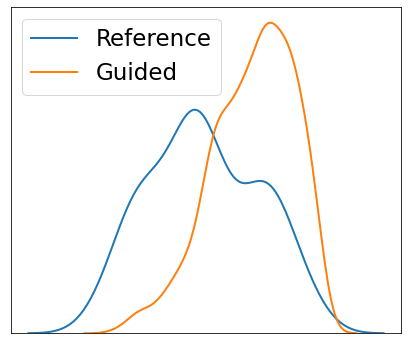

In [21]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Create original data distribution (e.g., Gaussian distribution)
data = [r['chem_results']['qed'] for r in ref.flat_results]
guided_data = [r['chem_results']['qed'] for r in bfn_opts['qed'].flat_results]

# Plotting the distributions
plt.figure(figsize=(7, 6))

# Original data distribution using KDE
sns.kdeplot(data, label='Reference', color='tab:blue', linewidth=2)

# Shifted data distribution (enhanced by gradient guidance) using KDE
sns.kdeplot(guided_data, label='Guided', color='tab:orange', linewidth=2)

# Adding titles and labels
# plt.title('Effect of Gradient Guidance on Data Distribution (Smooth)', fontsize=14)
plt.xlabel('')
plt.ylabel('')
plt.xticks([])
plt.yticks([])

# Add legend
plt.legend(loc='upper left', fontsize=23)

# Show plot
plt.savefig('guided_distribution.svg', dpi=300)

In [1]:
# collect the results of vina_score (avg, med), vina_min (avg, med), qed, sa for bfn_opts
import numpy as np
import sys
sys.path.append('..')
from core.evaluation.utils.scoring_func import obey_lipinski
from eval_all_results import ModelResults

# An example of accessing the results
def get_prop_list(model, prop):
    if prop == 'lipinski':
        return [obey_lipinski(res['mol']) for res in model.flat_results]
    elif prop == 'vina':
        return [res['vina']['score_only'][0]['affinity'] for res in model.flat_results]
    elif prop in ['qed', 'sa']:
        return [res['chem_results'][prop] for res in model.flat_results]
    else:
        raise ValueError(f"Unknown property {prop}")

results = []
# for model in sbdd_models:
# decompopt = ModelResults('DecompOpt', '/sharefs/share/sbdd_data/opt_results/decompopt_20_vina_docked.pt')
model = ModelResults('TAGMol', '/sharefs/share/sbdd_data/opt_results/tagmol_vina_docked.pt')
model = ModelResults('Ours', '/sharefs/share/sbdd_data/opt_results/ours_back130_vina_sa_50x100.pt')
model = ModelResults('IPDiff', '/sharefs/share/sbdd_data/all_results/ipdiff_vina_docked.pt')
model.load_vina_docked()
for model in [model]:
    vina_score = [r['vina']['score_only'][0]['affinity'] for r in model.flat_results]
    vina_min = [r['vina']['minimize'][0]['affinity'] for r in model.flat_results]
    vina_dock = [r['vina']['dock'][0]['affinity'] for r in model.flat_results]
    qed = [r['chem_results']['qed'] for r in model.flat_results]
    sa = [r['chem_results']['sa'] for r in model.flat_results]
    lip = [obey_lipinski(r['mol']) for r in model.flat_results]
    vina_score = np.array(vina_score)
    vina_min = np.array(vina_min)
    vina_dock = np.array(vina_dock)
    qed = np.array(qed)
    sa = np.array(sa)
    lip = np.array(lip)
    results.append({
        'vina_score_5%': np.percentile(vina_score, 5),
        'vina_score_avg': sum(vina_score) / len(vina_score),
        'vina_score_med': sorted(vina_score)[len(vina_score) // 2],
        'vina_min_5%': np.percentile(vina_min, 5),
        'vina_min_avg': sum(vina_min) / len(vina_min),
        'vina_min_med': sorted(vina_min)[len(vina_min) // 2],
        'vina_dock_5%': np.percentile(vina_dock, 5),
        'vina_dock_avg': sum(vina_dock) / len(vina_dock),
        'vina_dock_med': sorted(vina_dock)[len(vina_dock) // 2],
        'lipinski': sum(lip) / len(lip),
        'lip_10%': np.percentile(lip, 10),
        'qed_avg': sum(qed) / len(qed),
        'qed_25%': np.percentile(qed, 75),
        'sa_avg': sum(sa) / len(sa),
        'sa_25%': np.percentile(sa, 75),
        'model': model.name
    })

IPDiff loaded 9010 vina docked results


In [2]:
import pandas as pd

df = pd.DataFrame(results)
# df = pd.concat([df, df_new])
df

,vina_score_5%,vina_score_avg,vina_score_med,vina_min_5%,vina_min_avg,vina_min_med,vina_dock_5%,vina_dock_avg,vina_dock_med,lipinski,lip_10%,qed_avg,qed_25%,sa_avg,sa_25%,model
0,-12.9833,-6.417101,-7.008,-13.40055,-7.448164,-7.483,-13.63085,-8.572005,-8.51,4.527081,4.0,0.519005,0.658754,0.594877,0.68,IPDiff


In [13]:
import pandas as pd

df = pd.DataFrame(results)
df

,vina_score_5%,vina_score_avg,vina_score_med,vina_min_5%,vina_min_avg,vina_min_med,lipinski,lip_10%,qed_avg,qed_25%,sa_avg,sa_25%,model
0,-9.97700,-6.361780,-6.462,-9.92790,-6.706660,-6.486,4.270000,2.0,0.475996,0.670121,0.727700,0.84,Reference
1,-12.13500,-6.586599,-7.044,-12.33840,-7.265450,-7.256,4.456295,3.0,0.503570,0.664086,0.685851,0.78,w/o Opt
2,-13.38330,-7.629457,-8.255,-13.50590,-8.263127,-8.426,4.481967,3.0,0.522670,0.673318,0.682350,0.78,w/ Opt vina
3,-13.03260,-6.783745,-7.297,-13.18960,-7.559224,-7.589,4.740142,4.0,0.659041,0.780116,0.669828,0.79,w/ Opt qed
4,-13.03900,-6.781488,-7.227,-13.37700,-7.779632,-7.645,4.568807,4.0,0.573185,0.701787,0.765953,0.88,w/ Opt sa
5,-12.34030,-6.594251,-7.073,-12.56030,-7.351583,-7.281,4.761026,4.0,0.574465,0.702288,0.692451,0.80,w/ Opt lipinski
6,-12.45500,-6.545261,-7.225,-12.73220,-7.382941,-7.518,4.752786,4.0,0.646469,0.778592,0.740253,0.86,w/ Opt qed_sa
7,-13.31275,-7.461769,-8.044,-13.66860,-8.177569,-8.199,4.751020,4.0,0.637131,0.766785,0.673327,0.79,w/ Opt vina_qed
8,-13.34270,-7.081270,-7.877,-13.54060,-8.049144,-8.205,4.600207,4.0,0.564652,0.692920,0.751219,0.86,w/ Opt vina_sa
9,-13.07030,-7.088814,-7.466,-13.26885,-7.787386,-7.758,4.725510,4.0,0.624882,0.751737,0.734592,0.86,w/ Opt vina_qed_sa


In [6]:
model.flat_results[0]['vina'], model.flat_results[0]['chem_results']

({'score_only': [{'affinity': -4.703, 'pose': None}],
  'minimize': [{'affinity': -5.275,
    'pose': 'REMARK Flexibility Score: inf\nREMARK Active torsions [ 2 ] -> [ 2 ]\nROOT\nATOM      1  N1  LIG L   1     133.273  53.441  33.220  1.00  0.00    -0.212 NA\nATOM      2  C1  LIG L   1     132.944  54.632  31.222  1.00  0.00     0.041 A \nATOM      3  C2  LIG L   1     134.549  53.889  33.257  1.00  0.00     0.162 A \nATOM      4  C3  LIG L   1     134.282  55.070  31.297  1.00  0.00     0.079 A \nATOM      5  F1  LIG L   1     134.624  56.990  28.254  1.00  0.00    -0.205 F \nATOM      6  C4  LIG L   1     132.768  55.847  29.115  1.00  0.00     0.039 A \nATOM      7  C5  LIG L   1     134.830  55.871  30.319  1.00  0.00     0.066 A \nATOM      8  N2  LIG L   1     135.031  54.691  32.330  1.00  0.00    -0.227 NA\nATOM      9  C6  LIG L   1     134.076  56.238  29.232  1.00  0.00     0.125 A \nATOM     10  C7  LIG L   1     132.206  55.047  30.103  1.00  0.00     0.016 A \nATOM     11

In [1]:
from eval_all_results import ModelResults
import os

result_dir = '/sharefs/share/sbdd_data/opt_results'

ref_path = os.path.join(result_dir, 'crossdocked_test_vina_docked.pt')
bfn_ref_path = os.path.join(result_dir, 'bfn_vina_docked.pt')
# bfn_ref_path = os.path.join(result_dir, 'decompopt-opt_prior-metrics.pt')

opt_objectives = [
    'vina', 'qed', 'sa', 'lipinski', # 'vina_qed', 'vina_sa', 'vina_qed_sa', 'vina_qed_sa_lipinski'
]

opt_dir = '..'
bfn_opt_paths = [
    os.path.join(opt_dir, f'mols-{obj}', 'temp_eval_all.pt') for obj in opt_objectives
]

ref = ModelResults('Reference', ref_path)
bfn_ref = ModelResults('w/o Opt', bfn_ref_path)
ref.load_vina_docked()
bfn_ref.load_vina_docked()

bfn_opts = {
    obj: ModelResults(f'w/ Opt {obj}', path) for obj, path in zip(opt_objectives, bfn_opt_paths)
}

models = [ref, bfn_ref] + list(bfn_opts.values())
for model in models[2:]:
    model.load_vina_docked_sdf(os.path.dirname(model.path))

reference loaded 100 vina docked results
Reference loaded 100 vina docked results


KeyError: 0

In [3]:
import torch

decompopt_results = torch.load(bfn_ref_path)

In [7]:
decompopt_results.keys()

dict_keys(['mol', 'qed', 'sa', 'vina_score', 'vina_min', 'vina_dock'])

In [5]:
decomp_mols = decompopt_results['mol']
len(decomp_mols), len(decomp_mols[0])

(100, 55)

In [8]:
total_num = 0
n_cnt = {}
for i, mols in enumerate(decomp_mols):
    if len(mols) > 100:
        n_cnt[i] = len(mols)
    assert len(mols) <= 600, f"{i}: {len(mols)}"
    total_num += len(mols)

total_num, n_cnt

(15853,
 {7: 111,
  9: 430,
  14: 507,
  20: 322,
  26: 169,
  27: 102,
  36: 315,
  37: 461,
  38: 382,
  41: 184,
  42: 502,
  47: 400,
  50: 216,
  52: 127,
  53: 279,
  54: 241,
  55: 153,
  57: 103,
  58: 382,
  59: 137,
  61: 270,
  63: 204,
  64: 221,
  67: 569,
  70: 257,
  71: 443,
  73: 215,
  74: 227,
  75: 254,
  76: 103,
  78: 370,
  79: 453,
  82: 235,
  85: 337,
  86: 259,
  87: 115,
  88: 173,
  90: 528,
  92: 144,
  94: 530,
  96: 599,
  97: 148,
  98: 191})

In [2]:
import sys
sys.path.append('..')
from eval_all_results import ModelResults
from core.evaluation.utils.scoring_func import compute_diversity
import numpy as np

ref = ModelResults('Reference', '/sharefs/share/sbdd_data/opt_results/crossdocked_test_vina_docked.pt')
ref.load_vina_docked()
ref_fns = [x['ligand_filename'] for x in ref.flat_results]

timestamp = 20240908-103152 # 0.969, w=0, Avg: 0.7318 | Med: 0.7466 
# timestamp = '20240908-011946' # 0.967, w=0, Avg: 0.7301 | Med: 0.7459 
model = ModelResults('Ours', f'/sharefs/qiukeyue/project/logs/qiukeyue_bfn_molopt/cfg/test/test_outputs/{timestamp}/mols-self/eval_all.pt')
model.load_vina_docked_sdf(os.path.dirname(model.path))
agg_results = [[] for _ in range(100)]
for res in model.flat_results:
    ligand_filename = res['ligand_filename']
    idx = ref_fns.index(ligand_filename)
    agg_results[idx].append(res)

diversity_list = compute_diversity(agg_results)
mean, median = np.mean(diversity_list), np.median(diversity_list)
print(f"{model.name}, diversity: mean = {mean}, median = {median}")

Reference loaded 100 vina docked results


Ours:   0%|          | 0/10000 [00:00<?, ?it/s]

Ours loaded 969 dina docked results
Ours has 969 to dump


pocket: 100%|██████████| 100/100 [00:27<00:00,  3.58it/s]

[Diversity] Avg: 0.7318 | Med: 0.7466 
Ours, diversity: mean = 0.7317776270870866, median = 0.746556796584134


In [7]:
timestamp = '20240908-015335' # 0.94, w=0.5, Avg: 0.7474 | Med: 0.7621 
# timestamp = '20240908-014518' # 0.973, w=-0.2, Avg: 0.7342 | Med: 0.7498 
# timestamp = '20240908-012009' # 0.957, w=-0.5, Avg: 0.7283 | Med: 0.7450 
# timestamp = '20240908-012425' # 0.973, w=0.15, Avg: 0.7366 | Med: 0.7518 
model = ModelResults('Ours', f'/sharefs/qiukeyue/project/logs/qiukeyue_bfn_molopt/cfg/test/test_outputs/{timestamp}/mols-self/eval_all.pt')
model.load_vina_docked_sdf(os.path.dirname(model.path))
agg_results = [[] for _ in range(100)]
for res in model.flat_results:
    ligand_filename = res['ligand_filename']
    idx = ref_fns.index(ligand_filename)
    agg_results[idx].append(res)

diversity_list = compute_diversity(agg_results)
mean, median = np.mean(diversity_list), np.median(diversity_list)
print(f"{model.name}, diversity: mean = {mean}, median = {median}")

Ours:   0%|          | 0/10000 [00:00<?, ?it/s]

Ours loaded 967 dina docked results
Ours has 967 to dump


pocket: 100%|██████████| 100/100 [00:37<00:00,  2.67it/s]

[Diversity] Avg: 0.7301 | Med: 0.7459 
Ours, diversity: mean = 0.7300980859640243, median = 0.7459138765622066


In [14]:
from core.config.config import Config
import glob

timestamps = "20240908-180819  20240908-183617  20240908-183826  20240908-183955  20240908-184007  20240908-184047  20240908-184151  20240908-184306  20240908-184413 20240908-183253  20240908-183802  20240908-183827  20240908-183958  20240908-184008  20240908-184103  20240908-184157  20240908-184309  20240908-204922"
timestamps = timestamps.split()
timestamps = sorted(timestamps)

for timestamp in timestamps:
    config = f'/sharefs/qiukeyue/project/logs/qiukeyue_bfn_molopt/correction/a168dc9/test_outputs/{timestamp}/config.yaml'
    cfg = Config(config)
    if cfg.evaluation.num_samples != 5 or cfg.evaluation.sample_steps != 200 or cfg.evaluation.objective != 'vina_sa': continue
    model_name = cfg.dynamics.sampling_strategy
    model = ModelResults(f'{timestamp}_{model_name}', f'/sharefs/qiukeyue/project/logs/qiukeyue_bfn_molopt/correction/a168dc9/test_outputs/{timestamp}/mols-vina_sa/eval_all.pt')
    if not os.path.exists(os.path.dirname(model.path)): continue
    model.load_vina_docked_sdf(os.path.dirname(model.path))
    if not model.flat_results: continue
    agg_results = [[] for _ in range(100)]
    for res in model.flat_results:
        ligand_filename = res['ligand_filename']
        idx = ref_fns.index(ligand_filename)
        agg_results[idx].append(res)

    diversity_list = compute_diversity(agg_results)
    mean, median = np.mean(diversity_list), np.median(diversity_list)
    # print(f"{model.name}, diversity: mean = {mean}, median = {median}")


20240908-183253_vanilla_back_200:   0%|          | 0/10000 [00:00<?, ?it/s]

20240908-183253_vanilla_back_200 loaded 486 dina docked results
20240908-183253_vanilla_back_200 has 486 to dump


pocket: 100%|██████████| 100/100 [00:09<00:00, 10.22it/s]

[Diversity] Avg: 0.7581 | Med: 0.7743 
20240908-183253_vanilla_back_200, diversity: mean = 0.7581093475934596, median = 0.7743282498184458


20240908-183617_vanilla_back_100:   0%|          | 0/10000 [00:00<?, ?it/s]

20240908-183617_vanilla_back_100 loaded 489 dina docked results
20240908-183617_vanilla_back_100 has 489 to dump


pocket: 100%|██████████| 100/100 [00:09<00:00, 10.81it/s]

[Diversity] Avg: 0.7511 | Med: 0.7639 
20240908-183617_vanilla_back_100, diversity: mean = 0.7510704347445181, median = 0.7639193491333569


20240908-183802_vanilla_back_60:   0%|          | 0/10000 [00:00<?, ?it/s]

20240908-183802_vanilla_back_60 loaded 490 dina docked results
20240908-183802_vanilla_back_60 has 490 to dump


pocket: 100%|██████████| 100/100 [00:12<00:00,  8.25it/s]

[Diversity] Avg: 0.7104 | Med: 0.7260 
20240908-183802_vanilla_back_60, diversity: mean = 0.7104438682103623, median = 0.7259825327510917


20240908-183827_vanilla_back_25:   0%|          | 0/10000 [00:00<?, ?it/s]

20240908-183827_vanilla_back_25 loaded 455 dina docked results
20240908-183827_vanilla_back_25 has 455 to dump


pocket: 100%|██████████| 100/100 [00:03<00:00, 26.77it/s]

[Diversity] Avg: 0.7571 | Med: 0.7561 
20240908-183827_vanilla_back_25, diversity: mean = 0.7571326129742494, median = 0.7561374795417348


20240908-183955_vanilla_back_75:   0%|          | 0/10000 [00:00<?, ?it/s]

20240908-183955_vanilla_back_75 loaded 490 dina docked results
20240908-183955_vanilla_back_75 has 490 to dump


pocket: 100%|██████████| 100/100 [00:09<00:00, 10.36it/s]

[Diversity] Avg: 0.7293 | Med: 0.7554 
20240908-183955_vanilla_back_75, diversity: mean = 0.7292696594718737, median = 0.7553606237816765


20240908-184007_vanilla_back_50:   0%|          | 0/10000 [00:00<?, ?it/s]

20240908-184007_vanilla_back_50 loaded 494 dina docked results
20240908-184007_vanilla_back_50 has 494 to dump


pocket: 100%|██████████| 100/100 [00:07<00:00, 13.57it/s]

[Diversity] Avg: 0.7526 | Med: 0.7624 
20240908-184007_vanilla_back_50, diversity: mean = 0.7525592914522324, median = 0.7624267505757347


20240908-184008_vanilla_back_125:   0%|          | 0/10000 [00:00<?, ?it/s]

20240908-184008_vanilla_back_125 loaded 486 dina docked results
20240908-184008_vanilla_back_125 has 486 to dump


pocket: 100%|██████████| 100/100 [00:07<00:00, 13.43it/s]

[Diversity] Avg: 0.7464 | Med: 0.7810 
20240908-184008_vanilla_back_125, diversity: mean = 0.7463807617649261, median = 0.7810158012211108


20240908-184103_vanilla_back_150:   0%|          | 0/10000 [00:00<?, ?it/s]

20240908-184103_vanilla_back_150 loaded 485 dina docked results
20240908-184103_vanilla_back_150 has 485 to dump


pocket: 100%|██████████| 100/100 [00:06<00:00, 14.32it/s]

[Diversity] Avg: 0.7502 | Med: 0.7753 
20240908-184103_vanilla_back_150, diversity: mean = 0.7501724544711944, median = 0.775330396475771


20240908-184151_vanilla_back_90:   0%|          | 0/10000 [00:00<?, ?it/s]

20240908-184151_vanilla_back_90 loaded 489 dina docked results
20240908-184151_vanilla_back_90 has 489 to dump


pocket: 100%|██████████| 100/100 [00:09<00:00, 11.09it/s]

[Diversity] Avg: 0.7405 | Med: 0.7707 
20240908-184151_vanilla_back_90, diversity: mean = 0.7404798482091125, median = 0.7706957691367082


20240908-184157_vanilla_back_130:   0%|          | 0/10000 [00:00<?, ?it/s]

20240908-184157_vanilla_back_130 loaded 485 dina docked results
20240908-184157_vanilla_back_130 has 485 to dump


pocket: 100%|██████████| 100/100 [00:10<00:00,  9.48it/s]

[Diversity] Avg: 0.7474 | Med: 0.7742 
20240908-184157_vanilla_back_130, diversity: mean = 0.7474211467047295, median = 0.7741935483870968


20240908-184306_vanilla_back_160:   0%|          | 0/10000 [00:00<?, ?it/s]

20240908-184306_vanilla_back_160 loaded 485 dina docked results
20240908-184306_vanilla_back_160 has 485 to dump


pocket: 100%|██████████| 100/100 [00:07<00:00, 12.56it/s]


[Diversity] Avg: 0.7420 | Med: 0.7700 
20240908-184306_vanilla_back_160, diversity: mean = 0.7420171885390607, median = 0.7700325732899023


20240908-184309_vanilla_back_190:   0%|          | 0/10000 [00:00<?, ?it/s]

20240908-184309_vanilla_back_190 loaded 489 dina docked results
20240908-184309_vanilla_back_190 has 489 to dump


pocket: 100%|██████████| 100/100 [00:12<00:00,  8.04it/s]

[Diversity] Avg: 0.7473 | Med: 0.7720 
20240908-184309_vanilla_back_190, diversity: mean = 0.7473393499631819, median = 0.7719868692730529


20240908-184413_vanilla_back_30:   0%|          | 0/10000 [00:00<?, ?it/s]

20240908-184413_vanilla_back_30 loaded 469 dina docked results
20240908-184413_vanilla_back_30 has 469 to dump


pocket: 100%|██████████| 100/100 [00:04<00:00, 20.01it/s]


[Diversity] Avg: 0.7666 | Med: 0.7715 
20240908-184413_vanilla_back_30, diversity: mean = 0.7666487289835774, median = 0.7715010877447426


20240908-204922_end_back_pmf:   0%|          | 0/10000 [00:00<?, ?it/s]

20240908-204922_end_back_pmf loaded 482 dina docked results
20240908-204922_end_back_pmf has 482 to dump


pocket: 100%|██████████| 100/100 [00:07<00:00, 13.46it/s]

[Diversity] Avg: 0.7516 | Med: 0.7671 
20240908-204922_end_back_pmf, diversity: mean = 0.7516068835012879, median = 0.7671464860287891


In [15]:
model = ModelResults('Ours100', '../mols100/20240722-021041/mols-vina_sa_out_docked/eval_all.pt')
model.load_vina_docked_sdf(os.path.dirname(model.path))

agg_results = [[] for _ in range(100)]
for res in model.flat_results:
    ligand_filename = res['ligand_filename']
    idx = ref_fns.index(ligand_filename)
    agg_results[idx].append(res)

# adapt the code snippit for agg_results into one line
agg_results = [[res for res in model.flat_results if ref_fns.index(res['ligand_filename']) == idx] for idx in range(100)]

diversity_list = compute_diversity(agg_results)
mean, median = np.mean(diversity_list), np.median(diversity_list)
print(f"{model.name}, diversity: mean = {mean}, median = {median}")

Ours100:   0%|          | 0/10000 [00:00<?, ?it/s]

Ours100 loaded 9700 dina docked results
Ours100 has 9700 to dump


pocket: 100%|██████████| 100/100 [50:35<00:00, 30.35s/it] 

[Diversity] Avg: 0.7514 | Med: 0.7714 
Ours100, diversity: mean = 0.7514207935698933, median = 0.7714285714285715


## Plot Single-Optimization Boxplot

In [1]:
import sys
sys.path.append('..')

from core.config.config import Config
import os
from eval_all_results import ModelResults

opt2name = {'vina': 'Affinity', 'qed': 'QED', 'sa': 'SA', 'lipinski': 'Lipinski', 'qed_sa': 'QED+SA', 'vina_qed': 'Affinity+QED', 'vina_sa': 'Affinity+SA', 'vina_qed_sa': 'Affinity+QED+SA', 'vina_qed_sa_lipinski': 'Affinity+QED+SA+Lipinski'}

bfn_opts = {}

timestamps = os.listdir('/sharefs/qiukeyue/project/logs/qiukeyue_bfn_molopt/correction/a168dc9/test_outputs')
print(timestamps)
for timestamp in timestamps:
    config = f'/sharefs/qiukeyue/project/logs/qiukeyue_bfn_molopt/correction/a168dc9/test_outputs/{timestamp}/config.yaml'
    cfg = Config(config)
    if cfg.evaluation.num_samples != 10 or cfg.evaluation.sample_steps != 200: continue
    if cfg.dynamics.sampling_strategy != 'vanilla_back_130' or cfg.evaluation.objective not in ['vina', 'sa', 'qed', 'lipinski']: continue
    model_name = opt2name[cfg.evaluation.objective]
    model = ModelResults(f'{model_name}', f'/sharefs/qiukeyue/project/logs/qiukeyue_bfn_molopt/correction/a168dc9/test_outputs/{timestamp}/mols-{cfg.evaluation.objective}/eval_all.pt')
    if not os.path.exists(os.path.dirname(model.path)): continue
    # model.load_vina_docked_sdf(os.path.dirname(model.path))
    model.load_vina_docked()
    bfn_opts[cfg.evaluation.objective] = model


['20240908-184413', '20240908-184007', '20240908-183955', '20240909-033023', '20240908-183826', '20240908-184047', '20240909-041836', '20240908-183802', '20240908-184309', '20240909-012922', '20240909-033453', '20240909-033232', '20240908-184103', '20240908-183827', '20240908-184151', '20240909-041753', '20240909-033412', '20240909-033428', '20240908-183958', '20240909-013149', '20240909-005415', '20240908-183253', '20240908-183617', '20240908-180819', '20240909-032421', '20240908-204922', '20240909-005243', '20240908-184157', '20240909-012733', '20240909-033538', '20240909-033206', '20240908-184008', '20240908-184306', '20240908-235154']
Lipinski loaded 977 vina docked results
QED loaded 993 vina docked results
Affinity loaded 897 vina docked results
SA loaded 988 vina docked results


In [15]:
import sys
sys.path.append('..')

from core.config.config import Config
import os
from eval_all_results import ModelResults

opt2name = {'vina': 'Affinity', 'qed': 'QED', 'sa': 'SA', 'lipinski': 'Lipinski', 'qed_sa': 'QED+SA', 'vina_qed': 'Affinity+QED', 'vina_sa': 'Affinity+SA', 'vina_qed_sa': 'Affinity+QED+SA', 'vina_qed_sa_lipinski': 'Affinity+QED+SA+Lipinski'}

bfn_opts = {}

timestamps = os.listdir('/sharefs/qiukeyue/project/logs/qiukeyue_bfn_molopt/correction/traj/test_outputs')
timestamps = os.listdir('/sharefs/qiukeyue/project/logs/qiukeyue_bfn_molopt/correction/a168dc9/test_outputs')

# timestamps = os.listdir('/sharefs/qiukeyue/project/logs/qiukeyue_bfn_molopt/train_tune_dloss_prob/5abbd93_8460_test/test_outputs')

print(timestamps)
for timestamp in timestamps:
    config = f'/sharefs/qiukeyue/project/logs/qiukeyue_bfn_molopt/train_tune_dloss_prob/5abbd93_8460_test/test_outputs/{timestamp}/config.yaml'
    config = f'/sharefs/qiukeyue/project/logs/qiukeyue_bfn_molopt/correction/traj/test_outputs/{timestamp}/config.yaml'
    config = f'/sharefs/qiukeyue/project/logs/qiukeyue_bfn_molopt/correction/a168dc9/test_outputs/{timestamp}/config.yaml'
    if not os.path.exists(config): continue
    try:
        cfg = Config(config)
        if cfg.evaluation.num_samples != 10 or cfg.evaluation.sample_steps != 200: continue
        # if cfg.dynamics.sampling_strategy != 'end_back_pmf': continue
        if cfg.dynamics.sampling_strategy != 'vanilla_back_130': continue
        if cfg.evaluation.objective != 'vina_sa': continue
        if cfg.evaluation.pos_grad_weight != 50 or cfg.evaluation.type_grad_weight != 50: continue
        print(timestamp, cfg.evaluation.guide_mode)
    except:
        continue

    # model_name = opt2name[cfg.evaluation.objective]
    # model = ModelResults(f'{model_name}', f'/sharefs/qiukeyue/project/logs/qiukeyue_bfn_molopt/correction/a168dc9/test_outputs/{timestamp}/mols-{cfg.evaluation.objective}/eval_all.pt')
    # if not os.path.exists(os.path.dirname(model.path)): continue
    # model.load_vina_docked_sdf(os.path.dirname(model.path))
    # model.load_vina_docked()
    # bfn_opts[cfg.evaluation.objective] = model


['20240908-184413', '20240908-184007', '20240908-183955', '20240909-033023', '20240908-183826', '20240908-184047', '20240909-041836', '20240908-183802', '20240908-184309', '20240909-012922', '20240909-033453', '20240909-033232', '20240908-184103', '20240908-183827', '20240908-184151', '20240909-041753', '20240909-033412', '20240909-033428', '20240908-183958', '20240909-013149', '20240909-005415', '20240908-183253', '20240908-183617', '20240908-180819', '20240909-032421', '20240908-204922', '20240909-005243', '20240908-184157', '20240909-012733', '20240909-033538', '20240909-033206', '20240908-184008', '20240908-184306', '20240908-235154']
20240909-041753 sample_mean


In [2]:
ref = ModelResults('Reference', '/sharefs/share/sbdd_data/opt_results/crossdocked_test_vina_docked.pt')
ref.load_vina_docked()

bfn_ref = ModelResults('w/o Opt', '/sharefs/share/sbdd_data/opt_results/bfn_vina_docked.pt')
bfn_ref.load_vina_docked()

Reference loaded 100 vina docked results
w/o Opt loaded 9667 vina docked results


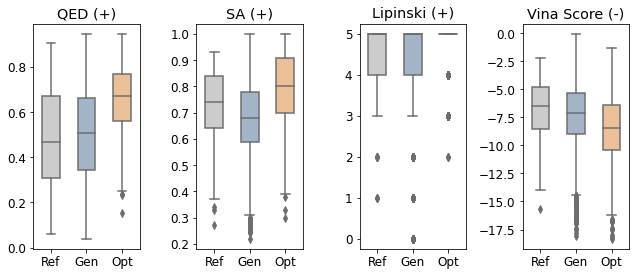

In [3]:
import sys
sys.path.append('..')

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import pandas as pd

from core.evaluation.utils.scoring_func import obey_lipinski

# An example of accessing the results
def get_prop_list(model, prop):
    if prop == 'lipinski':
        return [obey_lipinski(res['mol']) for res in model.flat_results]
    elif prop == 'vina':
        return [res['vina']['score_only'][0]['affinity'] for res in model.flat_results]
    elif prop in ['qed', 'sa']:
        return [res['chem_results'][prop] for res in model.flat_results]
    else:
        raise ValueError(f"Unknown property {prop}")



# set matplotlib font size to a larger one
plt.rcParams.update({'font.size': 12})
# set legend font size smaller
plt.rcParams.update({
    'legend.fontsize': '12',
    # 'legend.handlelength': 2
})

# colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple', 'tab:brown', 'tab:pink', 'tab:gray', 'tab:olive']
colors = ['#9DB4CE', # blue
          '#EDA1A4', # red
          '#F9C08A', # orange
          '#A4CB9E', # green
          '#B3D8D5'] # another green
ref_model = ref

# combine all properties into one plot

plt.figure(figsize=(3*3, 4))
plt.ylabel('Density')

for idx, prop in enumerate(['qed', 'sa', 'lipinski', 'vina']):
    plt.subplot(1, 4, idx+1)
    model = bfn_opts[prop]
    prop_list = get_prop_list(model, prop)
    ref_prop_list = get_prop_list(ref_model, prop)
    gen_prop_list = get_prop_list(bfn_ref, prop)
    # plot binned histogram with density for each property
    if prop in ['qed', 'sa']:
        prop_name = prop.upper() + ' (+)'
    elif prop == 'vina':
        prop_list = [aff for aff in prop_list if aff < 0]
        ref_prop_list = [aff for aff in ref_prop_list if aff < 0]
        gen_prop_list = [aff for aff in gen_prop_list if aff < 0]
        prop_name = 'Vina Score (-)'
    
    if prop in ['qed', 'sa', 'vina']:
        ref_prop_hist = np.histogram(ref_prop_list, bins=50)
        prop_hist = np.histogram(prop_list, bins=50)
        # gen_prop_hist = np.histogram(gen_prop_list, bins=50)
        # plt.hist(ref_prop_list, bins=50, label=ref_model.name, alpha=0.5, color='tab:gray', density=True)
        # plt.hist(gen_prop_list, bins=50, label=bfn_ref.name, alpha=0.5, color=colors[0], density=True)
        # plt.hist(prop_list, bins=50, label=model.name, alpha=0.5, color=colors[1+idx], density=True)
        
        sns.boxplot(data=[ref_prop_list, gen_prop_list, prop_list],width=0.5, palette=['.8', colors[0], colors[2]])
        plt.xticks([0,1,2], ['Ref', 'Gen', 'Opt'])

    elif prop == 'lipinski':
        prop_name = prop.capitalize() + ' (+)'
        x = np.arange(6)
        ref_prop_arr = np.array(ref_prop_list)
        prop_arr = np.array(prop_list)
        ref_prop_arr = np.array([np.sum(ref_prop_arr == i) for i in range(6)]) / len(ref_prop_arr)
        prop_arr = np.array([np.sum(prop_arr == i) for i in range(6)]) / len(prop_arr)
        # gen_prop_arr = np.array(gen_prop_list)
        # gen_prop_arr = np.array([np.sum(gen_prop_arr == i) for i in range(6)]) / len(gen_prop_arr)
        ref_dict = [{'x': i, 'y': ref_prop_arr[i], 'hue': ref_model.name} for i in range(6)]
        prop_dict = [{'x': i, 'y': prop_arr[i], 'hue': model.name} for i in range(6)]
        # gen_dict = [{'x': i, 'y': gen_prop_arr[i], 'hue': bfn_ref.name} for i in range(6)]
        data_all = ref_dict + prop_dict
        data_all = pd.DataFrame(data_all)
        # sns.barplot(data=data_all, x='x', y='y', hue='hue', palette=['tab:gray', colors[0], colors[1+idx]])
        sns.boxplot(data=[ref_prop_list, gen_prop_list, prop_list], width=0.5, palette=['.8', colors[0], colors[1]])
        # set x ticks
        plt.xticks([0,1,2], ['Ref', 'Gen', 'Opt'])
 
    else:
        raise ValueError(f"Unknown property {prop}")
    
    # set legend
    # plt.legend()
    plt.ylabel('')
    plt.xlabel('')
    plt.title(f'{prop_name}')

plt.tight_layout()
plt.savefig('all_dist.pdf', bbox_inches='tight', dpi=300)

In [5]:
""" 
w/o Guide	Vanilla	-5.23	-5.81	-6.3	-6.17	0.46	0.62
	Vanilla MC	-6.25	-6.7	-7.01	-7.05	0.51	0.61
	MolCRAFT	-6.22	-6.94	-7.14	-7.13	0.49	0.68
	B.C.	-6.5	-7	-7.03	-7.14	0.49	0.69
Guided	Vanilla	-5.47	-5.89	-6.29	-6.31	0.46	0.62
	Vanilla MC	-6.62	-7.27	-7.74	-7.79	0.55	0.65
	MolCRAFT	-7.42	-7.98	-8.25	-8.24	0.54	0.76
	B.C.	-7.52	-8.06	-8.34	-8.4	0.56	0.77
"""

import numpy as np
import matplotlib.pyplot as plt

# data to plot
n_groups = 6
means_frank = (-5.23, -5.81, -6.3, -6.17, 0.46, 0.62)
means_guided = (-5.47, -5.89, -6.29, -6.31, 0.46, 0.62)
means_frank_mc = (-6.25, -6.7, -7.01, -7.05, 0.51, 0.61)
means_guided_mc = (-6.62, -7.27, -7.74, -7.79, 0.55, 0.65)
means_frank_molcraft = (-6.22, -6.94, -7.14, -7.13, 0.49, 0.68)
means_guided_molcraft = (-7.42, -7.98, -8.25, -8.24, 0.54, 0.76)
means_frank_bc = (-6.5, -7, -7.03, -7.14, 0.49, 0.69)
means_guided_bc = (-7.52, -8.06, -8.34, -8.4, 0.56, 0.77)

# convert to positive values
means_frank = [abs(x) for x in means_frank]
means_guided = [abs(x) for x in means_guided]
means_frank_mc = [abs(x) for x in means_frank_mc]
means_guided_mc = [abs(x) for x in means_guided_mc]
means_frank_molcraft = [abs(x) for x in means_frank_molcraft]
means_guided_molcraft = [abs(x) for x in means_guided_molcraft]
means_frank_bc = [abs(x) for x in means_frank_bc]
means_guided_bc = [abs(x) for x in means_guided_bc]

# calculate the percentage of improvement of guided over w/o guide
improvement = np.array(means_guided) - np.array(means_frank)
improvement = improvement / np.array(means_frank) * 100
improvement_mc = np.array(means_guided_mc) - np.array(means_frank_mc)
improvement_mc = improvement_mc / np.array(means_frank_mc) * 100
improvement_molcraft = np.array(means_guided_molcraft) - np.array(means_frank_molcraft)
improvement_molcraft = improvement_molcraft / np.array(means_frank_molcraft) * 100
improvement_bc = np.array(means_guided_bc) - np.array(means_frank_bc)
improvement_bc = improvement_bc / np.array(means_frank_bc) * 100

# print the improvement percentage in the format of x.x%
improvement = [f"{x:.1f}%" for x in improvement]
improvement_mc = [f"{x:.1f}%" for x in improvement_mc]
improvement_molcraft = [f"{x:.1f}%" for x in improvement_molcraft]
improvement_bc = [f"{x:.1f}%" for x in improvement_bc]

print(improvement)
print(improvement_mc)
print(improvement_molcraft)
print(improvement_bc)

# create plot
# fig, ax = plt.subplots()
# index = np.arange(n_groups)
# bar_width = 0.35
# opacity = 0.8

# rects1 = plt.bar(index, means_frank, bar_width,
# alpha=opacity,
# color='b',
# label='Frank')

# rects2 = plt.bar(index + bar_width, means_guided, bar_width,
# alpha=opacity,
# color='g',
# label='Guided')

# plt.xlabel('Metrics')
# plt.ylabel('Scores')
# plt.title('Scores by metrics')
# plt.xticks(index + bar_width, ('Vina Score Avg', 'Vina Score Med', 'Vina Min Avg', 'Vina Min Med', 'QED', 'SA'))
# plt.legend()

# plt.tight_layout()
# plt.show()

['4.6%', '1.4%', '-0.2%', '2.3%', '0.0%', '0.0%']
['5.9%', '8.5%', '10.4%', '10.5%', '7.8%', '6.6%']
['19.3%', '15.0%', '15.5%', '15.6%', '10.2%', '11.8%']
['15.7%', '15.1%', '18.6%', '17.6%', '14.3%', '11.6%']


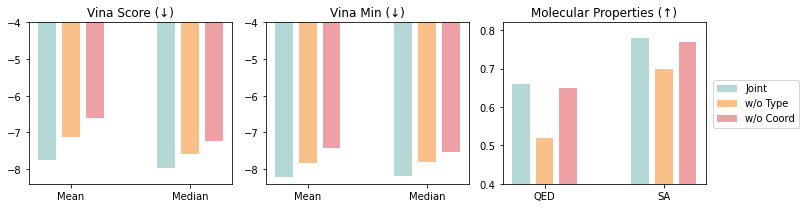

In [3]:
""" 
Objective	Methods	Vina Score 		Vina Min 	QED 	SA 
		Avg.	Med.	Avg.	Med.		
Affinity	Ours	-7.74	-7.96	-8.21	-8.19	0.52	0.68
	w/o type	-7.13	-7.58	-7.82	-7.8	0.5	0.66
	w/o coord	-6.61	-7.23	-7.42	-7.53	0.52	0.71
QED	Ours	-6.84	-7.32	-7.54	-7.65	0.66	0.7
	w/o type	-6.41	-7.03	-7.2	-7.26	0.52	0.67
	w/o coord	-6.5	-7.2	-7.44	-7.42	0.65	0.7
SA	Ours	-6.25	-7.24	-7.48	-7.65	0.57	0.78
	w/o type	-6.29	-6.85	-7.07	-7.09	0.51	0.7
	w/o coord	-6.71	-7.22	-7.6	-7.6	0.57	0.77
"""

import numpy as np
import matplotlib.pyplot as plt

# data to plot
n_groups = 6
aff_joint = (-7.74, -7.96, -8.21, -8.19, 0.52, 0.68)
aff_no_type = (-7.13, -7.58, -7.82, -7.8, 0.5, 0.66)
aff_no_coord = (-6.61, -7.23, -7.42, -7.53, 0.52, 0.71)

qed_joint = (-6.84, -7.32, -7.54, -7.65, 0.66, 0.7)
qed_no_type = (-6.41, -7.03, -7.2, -7.26, 0.52, 0.67)
qed_no_coord = (-6.5, -7.2, -7.44, -7.42, 0.65, 0.7)

sa_joint = (-6.25, -7.24, -7.48, -7.65, 0.57, 0.78)
sa_no_type = (-6.29, -6.85, -7.07, -7.09, 0.51, 0.7)
sa_no_coord = (-6.71, -7.22, -7.6, -7.6, 0.57, 0.77)

# only plot aff for aff, qed for qed, sa for sa

# Creating a figure with subplots
fig, axs = plt.subplots(1, 3, figsize=(10, 3)) # Adjust the size as needed

x = np.arange(2)
width = 0.2

colors = ['#B3D8D5', '#F9C08A', '#EDA1A4', '#E7C1D7', '#AFB0D0']
# colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
ALPHA = 1

# Plotting the Vina scores
# axs[0].xticks(x, ['w/o Correction', 'w/ Correction'])
axs[0].bar(x - width, aff_joint[:2], width - 0.05, label='Joint', color=colors[0], alpha=ALPHA)
axs[0].bar(x, aff_no_type[:2], width - 0.05, label='w/o Type', color=colors[1], alpha=ALPHA)
axs[0].bar(x + width, aff_no_coord[:2], width - 0.05, label='w/o Coord', color=colors[2], alpha=ALPHA)
axs[0].set_title('Vina Score (↓)')
axs[0].set_xticks(x)
axs[0].set_xticklabels(['Mean', 'Median'])
axs[0].set_ylim(-8.4, -4)

# Plotting the Vina min scores
axs[1].bar(x - width, aff_joint[2:4], width - 0.05, label='Joint', color=colors[0], alpha=ALPHA)
axs[1].bar(x, aff_no_type[2:4], width - 0.05, label='w/o Type', color=colors[1], alpha=ALPHA)
axs[1].bar(x + width, aff_no_coord[2:4], width - 0.05, label='w/o Coord', color=colors[2], alpha=ALPHA)
axs[1].set_title('Vina Min (↓)')
axs[1].set_xticks(x)
axs[1].set_xticklabels(['Mean', 'Median'])
axs[1].set_ylim(-8.4, -4)

# Plotting the QED & SA
axs[2].bar(x - width, [qed_joint[4], sa_joint[5]], width - 0.05, label='Joint', color=colors[0], alpha=ALPHA)
axs[2].bar(x, [qed_no_type[4], sa_no_type[5]], width - 0.05, label='w/o Type', color=colors[1], alpha=ALPHA)
axs[2].bar(x + width, [qed_no_coord[4], sa_no_coord[5]], width - 0.05, label='w/o Coord', color=colors[2], alpha=ALPHA)
axs[2].set_title('Molecular Properties (↑)')
axs[2].set_xticks(x)
axs[2].set_xticklabels(['QED', 'SA'])
axs[2].set_ylim(0.4, 0.82)

# Collect labels and handles
handles, labels = [], []
for ax in axs[:1]:
    for h, l in zip(*ax.get_legend_handles_labels()):
        handles.append(h)
        labels.append(l)

# Create one legend
fig.legend(handles, labels, loc='center right', bbox_to_anchor=(1.122, 0.5)) #'upper center', bbox_to_anchor=(0.5, 0.0), ncol=len(handles))

# Adjust layout to prevent overlap
plt.tight_layout()

# Show plot
plt.savefig('ablation_joint.pdf', dpi=300, bbox_inches='tight')

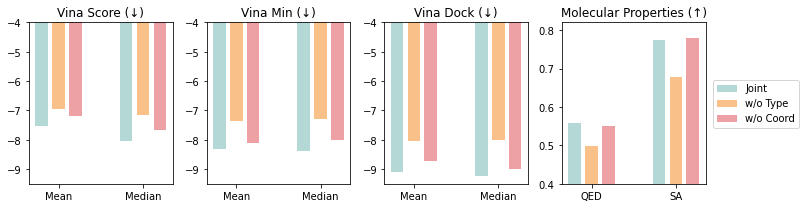

In [2]:
""" 
Joint 
Evaluate done! 999 samples in total.
complete:     0.9720
Number of evaluated mols: 971
QED:   Mean: 0.558 Median: 0.573
SA:    Mean: 0.773 Median: 0.760
Vina Score:  Mean: -7.522 Median: -8.058
Vina Min  :  Mean: -8.303 Median: -8.369
Vina Dock :  Mean: -9.109 Median: -9.250
Success rate: 0.518

w/o Type
Evaluate done! 997 samples in total.
complete:	0.9569
Number of evaluated mols: 954
QED:   Mean: 0.499 Median: 0.505
SA:    Mean: 0.677 Median: 0.680
Vina Score:  Mean: -6.940 Median: -7.157
Vina Min  :  Mean: -7.350 Median: -7.303
Vina Dock :  Mean: -8.029 Median: -7.995
Success rate: 0.270

w/o Coord
Evaluate done! 997 samples in total.
complete:	0.9960
Number of evaluated mols: 993
QED:   Mean: 0.550 Median: 0.564
SA:    Mean: 0.780 Median: 0.790
Vina Score:  Mean: -7.189 Median: -7.661
Vina Min  :  Mean: -8.097 Median: -8.003
Vina Dock :  Mean: -8.734 Median: -9.004
Success rate: 0.460

"""

import numpy as np
import matplotlib.pyplot as plt

# data to plot
n_groups = 6
aff_joint = (-7.522, -8.058, -8.303, -8.369, -9.109, -9.250)
aff_no_type = (-6.940, -7.157, -7.350, -7.303, -8.029, -7.995)
aff_no_coord = (-7.189, -7.661, -8.097, -8.003, -8.734, -9.004)

qed_joint = (0.558, 0.573, 0.773, 0.760, -7.522, -8.058)
qed_no_type = (0.499, 0.505, 0.677, 0.680, -6.940, -7.157)
qed_no_coord = (0.550, 0.564, 0.780, 0.790, -7.189, -7.661)

sa_joint = (0.773, 0.760, 0.773, 0.760, -7.522, -8.058)
sa_no_type = (0.677, 0.680, 0.677, 0.680, -6.940, -7.157)
sa_no_coord = (0.780, 0.790, 0.780, 0.790, -7.189, -7.661)

# only plot aff for aff, qed for qed, sa for sa

# Creating a figure with subplots
fig, axs = plt.subplots(1, 4, figsize=(10, 3)) # Adjust the size as needed

x = np.arange(2)
width = 0.2

colors = ['#B3D8D5', '#F9C08A', '#EDA1A4', '#E7C1D7', '#AFB0D0']
# colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
ALPHA = 1

# Plotting the Vina scores
# axs[0].xticks(x, ['w/o Correction', 'w/ Correction'])
axs[0].bar(x - width, aff_joint[:2], width - 0.05, label='Joint', color=colors[0], alpha=ALPHA)
axs[0].bar(x, aff_no_type[:2], width - 0.05, label='w/o Type', color=colors[1], alpha=ALPHA)
axs[0].bar(x + width, aff_no_coord[:2], width - 0.05, label='w/o Coord', color=colors[2], alpha=ALPHA)
axs[0].set_title('Vina Score (↓)')
axs[0].set_xticks(x)
axs[0].set_xticklabels(['Mean', 'Median'])
axs[0].set_ylim(-9.5, -4)

# Plotting the Vina min scores
axs[1].bar(x - width, aff_joint[2:4], width - 0.05, label='Joint', color=colors[0], alpha=ALPHA)
axs[1].bar(x, aff_no_type[2:4], width - 0.05, label='w/o Type', color=colors[1], alpha=ALPHA)
axs[1].bar(x + width, aff_no_coord[2:4], width - 0.05, label='w/o Coord', color=colors[2], alpha=ALPHA)
axs[1].set_title('Vina Min (↓)')
axs[1].set_xticks(x)
axs[1].set_xticklabels(['Mean', 'Median'])
axs[1].set_ylim(-9.5, -4)

# Plotting the Vina Dock scores
axs[2].bar(x - width, aff_joint[4:], width - 0.05, label='Joint', color=colors[0], alpha=ALPHA)
axs[2].bar(x, aff_no_type[4:], width - 0.05, label='w/o Type', color=colors[1], alpha=ALPHA)
axs[2].bar(x + width, aff_no_coord[4:], width - 0.05, label='w/o Coord', color=colors[2], alpha=ALPHA)
axs[2].set_title('Vina Dock (↓)')
axs[2].set_xticks(x)
axs[2].set_xticklabels(['Mean', 'Median'])
axs[2].set_ylim(-9.5, -4)

# Plotting the QED & SA
axs[3].bar(x - width, [qed_joint[0], sa_joint[0]], width - 0.05, label='Joint', color=colors[0], alpha=ALPHA)
axs[3].bar(x, [qed_no_type[0], sa_no_type[0]], width - 0.05, label='w/o Type', color=colors[1], alpha=ALPHA)
axs[3].bar(x + width, [qed_no_coord[0], sa_no_coord[0]], width - 0.05, label='w/o Coord', color=colors[2], alpha=ALPHA)
axs[3].set_title('Molecular Properties (↑)')
axs[3].set_xticks(x)
axs[3].set_xticklabels(['QED', 'SA'])
axs[3].set_ylim(0.4, 0.82)

# Collect labels and handles
handles, labels = [], []
for ax in axs[:1]:
    for h, l in zip(*ax.get_legend_handles_labels()):
        handles.append(h)
        labels.append(l)

# Create one legend
fig.legend(handles, labels, loc='center right', bbox_to_anchor=(1.122, 0.5)) #'upper center', bbox_to_anchor=(0.5, 0.0), ncol=len(handles))

# Adjust layout to prevent overlap
plt.tight_layout()

# Show plot
plt.savefig('ablation_joint2.pdf', dpi=300, bbox_inches='tight')

## Calculate diversity, similarity & so on

In [25]:
import numpy as np
import sys
sys.path.append('..')
from eval_all_results import ModelResults
import os
import torch

result_dir = '/sharefs/share/sbdd_data/opt_results'

ref_path = os.path.join(result_dir, 'crossdocked_test_vina_docked.pt')
# bfn_ref_path = os.path.join(result_dir, 'bfn_vina_docked.pt')
ref = ModelResults('Reference', ref_path)
# bfn_ref = ModelResults('w/o Opt', bfn_ref_path)
ref.load_vina_docked()
# bfn_ref.load_pose_checked()


affinity = 'dock'

def compute_high_affinity(vina_ref, results):
    percentage_good = []
    num_docked = []
    qed_good, sa_good = [], []
    for i in range(100):
        score_ref = vina_ref[i]
        pocket_results = [r for r in results[i] if r['vina'] is not None]
        # if len(pocket_results) < 50:
        #     continue
        num_docked.append(len(pocket_results))

        scores_gen = []
        for docked in pocket_results:
            aff = docked['vina'][affinity][0]['affinity']
            scores_gen.append(aff)
            if aff <= score_ref:
                qed_good.append(docked['chem_results']['qed'])
                sa_good.append(docked['chem_results']['sa'])
        scores_gen = np.array(scores_gen)
        if len(scores_gen) == 0:
            continue
        percentage_good.append((scores_gen <= score_ref).mean())

    percentage_good = np.array(percentage_good)
    num_docked = np.array(num_docked)

    print('[HF%%]  Avg: %.2f%% | Med: %.2f%% ' % (np.mean(percentage_good)*100, np.median(percentage_good)*100))
    print('[HF-QED]  Avg: %.4f | Med: %.4f ' % (np.mean(qed_good)*100, np.median(qed_good)*100))
    print('[HF-SA]   Avg: %.4f | Med: %.4f ' % (np.mean(sa_good)*100, np.median(sa_good)*100))
    print('[Success%%] %.2f%% ' % (np.mean(percentage_good > 0)*100, ))
    return percentage_good, qed_good, sa_good

ref_fns = [x['ligand_filename'] for x in ref.flat_results]
vina_ref = [r['vina'][affinity][0]['affinity'] for r in ref.flat_results]
# model_tbd = bfn_opts['vina_qed_sa']

# model_tbd = bfn_ref
# model_tbd = ModelResults('w/ Inpaint ref', '../mols-inpaint/mols_ref20/temp_eval_all.pt')
# model_tbd = ModelResults('w/ Inpaint vina_sa ref', '../mols-inpaint/mols-vina_sa_ref20/temp_eval_all.pt')
# model_tbd = ModelResults('w/ scaffold vina_qed_sa ref', '../mols-scaffold/mols-vina_qed_sa_ref20_scaffold/temp_eval_all.pt')
# model_tbd = ModelResults('w/ scaffold ref', '../mols-scaffold/mols_ref20_scaffold/temp_eval_all.pt')
# model_tbd = ModelResults('Ours-O', os.path.join(result_dir, 'bfn_dcmp_vina_sa_50_vina_docked.pt'))
# model_tbd = ModelResults('FLAG', os.path.join('/sharefs/share/sbdd_data/all_results', 'flag_vina_docked.pt'))
# model_tbd = ModelResults('MolCRAFT', os.path.join(result_dir, 'molcraft_inpainting_ref20_vina_docked.pt'))
# flat_results = model_tbd.flat_results
flat_results = torch.load(os.path.join(result_dir, 'molcraft_inpainting_ref20_vina_docked.pt'), map_location='cpu')

agg_results = [[] for _ in range(100)]
for res in flat_results:
    ligand_filename = res['ligand_filename']
    idx = ref_fns.index(ligand_filename)
    agg_results[idx].append(res)

percentage_good, qed_good, sa_good = compute_high_affinity(vina_ref, agg_results)

qed_list = [r['chem_results']['qed'] for r in flat_results]
sa_list = [r['chem_results']['sa'] for r in flat_results]
vina_dock_list = [r['vina']['dock'][0]['affinity'] for r in model_tbd.flat_results]
success_rate = (np.array(qed_list) > 0.25) & (np.array(sa_list) > 0.59) & (np.array(vina_dock_list) < -8.18)
success_rate = success_rate.sum() / len(success_rate)
print(f"[Success rate%]: {success_rate}")


Reference loaded 100 vina docked results



KeyboardInterrupt



In [7]:
import io
with open(os.path.join(result_dir, 'molcraft_inpainting_ref20_vina_docked.pt'), 'rb') as f:
    buf = io.BytesIO(f.read())
    flat_results = torch.load(buf, map_location='cpu')['all_results']

RuntimeError: Bad pickle format: ENDMOL tag not found.

In [ ]:
from core.evaluation.utils.scoring_func import compute_similarity, compute_novelty, compute_uniqueness, compute_scaffold_similarity, compute_diversity

nov = compute_novelty(agg_results)
uniq = compute_uniqueness(agg_results)
sim = compute_similarity(agg_results)
div = compute_diversity(agg_results)

In [3]:
from collections import Counter
from copy import deepcopy

import numpy as np
from scipy.spatial.distance import cosine as cos_distance

from rdkit import Chem, DataStructs
from rdkit.Chem import AllChem, Descriptors, Crippen, Lipinski
from rdkit.Chem.FilterCatalog import *
from rdkit.Chem.QED import qed
from rdkit.Chem.Scaffolds import MurckoScaffold


from tqdm import tqdm
from core.evaluation.utils.sascorer import compute_sa_score



def compute_scaffold_similarity(results, refs, min_rings=2):
    scaffold_similarity = []
    for i, res in tqdm(enumerate(results), total=len(results), desc='pocket scaffold sim'):
        pocket_results = [r for r in res if r['mol'] is not None]

        mols = [r['mol'] for r in pocket_results]
        scaffold_mol = compute_scaffolds(mols, min_rings=min_rings)
        scaffold_ref = compute_scaffolds([refs[i]], min_rings=min_rings)
        if len(scaffold_mol) == 0 or len(scaffold_ref) == 0:
            if len(scaffold_ref) == 0:
                print('No scaffold found for mols', i, pocket_results[0]['ligand_filename'])
            continue
        scaffold_similarity.append(cos_similarity(scaffold_ref, scaffold_mol))
    scaffold_similarity = np.array(scaffold_similarity)
    print('[Scaffold Similarity] Avg: %.4f | Med: %.4f ' % (np.mean(scaffold_similarity), np.median(scaffold_similarity)))
    return scaffold_similarity


def compute_scaffolds(mol_list, n_jobs=1, min_rings=2):
    """
    Extracts a scafold from a molecule in a form of a canonic SMILES
    """
    def compute_scaffold(mol, min_rings=2):
        try:
            scaffold = MurckoScaffold.GetScaffoldForMol(mol)
        except (ValueError, RuntimeError):
            # print('Failed to compute scaffold for mol', mol)
            return None
        n_rings = scaffold.GetRingInfo().NumRings()
        scaffold_smiles = Chem.MolToSmiles(scaffold)
        if scaffold_smiles == '' or n_rings < min_rings:
            # print('Failed to compute scaffold for scaffold smi', scaffold_smiles, n_rings, min_rings)
            return None
        return scaffold_smiles

    scaffolds = Counter(
        [compute_scaffold(mol, min_rings=min_rings) for mol in mol_list])
    if None in scaffolds:
        scaffolds.pop(None)
    return scaffolds


def cos_similarity(ref_counts, gen_counts):
    """
    Computes cosine similarity between
     dictionaries of form {name: count}. Non-present
     elements are considered zero:

     sim = <r, g> / ||r|| / ||g||
    """
    if len(ref_counts) == 0 or len(gen_counts) == 0:
        return np.nan
    keys = np.unique(list(ref_counts.keys()) + list(gen_counts.keys()))
    ref_vec = np.array([ref_counts.get(k, 0) for k in keys])
    gen_vec = np.array([gen_counts.get(k, 0) for k in keys])
    return 1 - cos_distance(ref_vec, gen_vec)



In [29]:
from core.evaluation.utils.scoring_func import compute_similarity, compute_novelty, compute_uniqueness, compute_scaffold_similarity, compute_diversity

def compute_uniqueness(results):
    unique = []
    smis = []
    for res in tqdm(results, desc='pocket uniq'):
        pocket_results = [r for r in res if r['mol'] is not None]

        mols = [r['mol'] for r in pocket_results]
        if len(mols) == 0: continue
        smis.extend([Chem.MolToSmiles(m) for m in mols])
    unique = len(set(smis)) / len(smis)
    print('[Uniqueness] Avg: %.4f ' % (np.mean(unique)))
    return unique


ref_mols = [r['mol'] for r in ref.flat_results]
# scasim = compute_scaffold_similarity(agg_results, ref_mols, min_rings=0)
# sim = compute_similarity(agg_results, ref_mols)
# nov = compute_novelty(agg_results, ref_mols)
uni = compute_uniqueness(agg_results)
# div = compute_diversity(agg_results)

pocket uniq: 100%|██████████| 100/100 [00:00<00:00, 759.66it/s]

[Uniqueness] Avg: 0.7116 


In [5]:
from rdkit.Chem import MACCSkeys
from rdkit.Chem.AllChem import GetMorganFingerprintAsBitVect as Morgan

def fingerprint(mol, fp_type='morgan', dtype=None, morgan__r=2,
                morgan__n=1024, *args, **kwargs):
    """
    Generates fingerprint for SMILES
    If smiles is invalid, returns None
    Returns numpy array of fingerprint bits

    Parameters:
        smiles: SMILES string
        type: type of fingerprint: [MACCS|morgan]
        dtype: if not None, specifies the dtype of returned array
    """
    fp_type = fp_type.lower()
    molecule = mol
    fingerprint = Morgan(molecule, morgan__r, nBits=morgan__n)
    # if molecule is None:
    #     return None
    # if fp_type == 'maccs':
    #     keys = MACCSkeys.GenMACCSKeys(molecule)
    #     keys = np.array(keys.GetOnBits())
    #     fingerprint = np.zeros(166, dtype='uint8')
    #     if len(keys) != 0:
    #         fingerprint[keys - 1] = 1  # We drop 0-th key that is always zero
    # elif fp_type == 'morgan':
    #     fingerprint = np.asarray(Morgan(molecule, morgan__r, nBits=morgan__n),
    #                              dtype='uint8')
    # else:
    #     raise ValueError("Unknown fingerprint type {}".format(fp_type))
    # if dtype is not None:
    #     fingerprint = fingerprint.astype(dtype)
    return fingerprint

def tanimoto_sim(mol, ref):
    # fp1 = Chem.RDKFingerprint(ref)
    # fp2 = Chem.RDKFingerprint(mol)
    fp1 = fingerprint(ref, fp_type='morgan')
    fp2 = fingerprint(mol, fp_type='morgan')
    return DataStructs.TanimotoSimilarity(fp1,fp2)


def compute_similarity(results, refs):
    similarity = []
    for i, res in tqdm(enumerate(results), total=len(results), desc='pocket sim'):
        pocket_results = [r for r in res if r['mol'] is not None]

        mols = [r['mol'] for r in pocket_results]
        for j in range(len(mols)):
            tmp = tanimoto_sim(mols[j], refs[i])
            similarity.append(tmp)
    similarity = np.array(similarity)
    print('[Similarity] Avg: %.4f | Med: %.4f ' % (np.mean(similarity), np.median(similarity)))
    return similarity

ref_mols = [r['mol'] for r in ref.flat_results]
similarity = compute_similarity(agg_results, ref_mols)

pocket sim: 100%|██████████| 100/100 [00:00<00:00, 717.91it/s]

[Similarity] Avg: 0.3655 | Med: 0.2099 


In [21]:
similarity = compute_similarity(agg_results, ref_mols)

pocket sim: 100%|██████████| 100/100 [00:00<00:00, 395.85it/s]

[Similarity] Avg: 0.2587 | Med: 0.2128 


In [14]:
flat_molist = [r['mol'] for r in model_tbd.flat_results if r['mol'] is not None]
scaffold_mols = compute_scaffolds(flat_molist, min_rings=2)
scaffold_ref = compute_scaffolds(ref_mols, min_rings=2)
scaffold_sim = cos_similarity(scaffold_ref, scaffold_mols)
print(f"Scaffold similarity: {scaffold_sim}")

Scaffold similarity: 0.13021221258589155


In [13]:
flat_molist = [r['mol'] for r in model_tbd.flat_results if r['mol'] is not None]
scaffold_mols = compute_scaffolds(flat_molist, min_rings=0)
scaffold_ref = compute_scaffolds(ref_mols, min_rings=0)
scaffold_sim = cos_similarity(scaffold_ref, scaffold_mols)
print(f"Scaffold similarity: {scaffold_sim}")

Scaffold similarity: 0.3860690253124064


In [10]:
# molcraft
flat_molist = [r['mol'] for r in model_tbd.flat_results if r['mol'] is not None]
scaffold_mols = compute_scaffolds(flat_molist, min_rings=0)
scaffold_ref = compute_scaffolds(ref_mols, min_rings=0)
scaffold_sim = cos_similarity(scaffold_ref, scaffold_mols)
print(f"Scaffold similarity: {scaffold_sim}")

Scaffold similarity: 0.36387067586000743


In [11]:
# molcraft
flat_molist = [r['mol'] for r in model_tbd.flat_results if r['mol'] is not None]
scaffold_mols = compute_scaffolds(flat_molist, min_rings=2)
scaffold_ref = compute_scaffolds(ref_mols, min_rings=2)
scaffold_sim = cos_similarity(scaffold_ref, scaffold_mols)
print(f"Scaffold similarity: {scaffold_sim}")

Scaffold similarity: 0.03181896284954011


In [3]:
print(f"[Similarity] Avg: {np.mean(sim):.2f} | Med: {np.median(sim):.2f}")
print(f"[Novelty] Avg: {np.mean(nov):.2f} | Med: {np.median(nov):.2f}")
print(f"[Uniqueness] Avg: {np.mean(uni):.2f} | Med: {np.median(uni):.2f}")
print(f"[Scaffold Similarity] Avg: {np.mean(scasim):.2f} | Med: {np.median(scasim):.2f}")

[Similarity] Avg: 0.44 | Med: 0.36
[Novelty] Avg: 0.86 | Med: 1.00
[Uniqueness] Avg: 0.74 | Med: 0.97
[Scaffold Similarity] Avg: nan | Med: nan


In [13]:
from core.evaluation.utils.scoring_func import compute_similarity

ref_mols = [r['mol'] for r in ref.flat_results]

bfn_large = ModelResults('BFN Large', os.path.join('/sharefs/share/sbdd_data/all_results', 'bfn_dcmpo_vina_docked.pt'))
bfn_large.load_pose_checked()
bfn_agg_results = [[] for _ in range(100)]
# for res in bfn_ref.flat_results:
for res in bfn_large.flat_results:
    ligand_filename = res['ligand_filename']
    idx = ref_fns.index(ligand_filename)
    bfn_agg_results[idx].append(res)

sim = compute_similarity(bfn_agg_results, ref_mols)
print(f"[Similarity] Avg: {np.mean(sim):.2f} | Med: {np.median(sim):.2f}")

BFN Large loaded 7042 pose checked results


pocket sim: 100%|██████████| 100/100 [00:38<00:00,  2.62it/s]

[Similarity] Avg: 0.2693 | Med: 0.2477 
[Similarity] Avg: 0.27 | Med: 0.25


In [26]:
sim = compute_similarity(agg_results, ref_mols)
print(f"[Similarity] Avg: {np.mean(sim):.2f} | Med: {np.median(sim):.2f}")

pocket sim: 100%|██████████| 100/100 [00:01<00:00, 91.95it/s]

[Similarity] Avg: 0.1247 | Med: 0.1148 
[Similarity] Avg: 0.12 | Med: 0.11


In [9]:
print(f"[Div]  Avg: {mean:.2f} | Med: {median:.2f}")
print('[HF%%]  Avg: %.2f%% | Med: %.2f%% ' % (np.mean(percentage_good)*100, np.median(percentage_good)*100))
print('[HF-QED]  Avg: %.4f | Med: %.4f ' % (np.mean(qed_good)*100, np.median(qed_good)*100))
print('[HF-SA]   Avg: %.4f | Med: %.4f ' % (np.mean(sa_good)*100, np.median(sa_good)*100))
# print('[Success%%] %.2f%% ' % (np.mean(percentage_good > 0)*100, ))
print(f"[Success rate%]: {success_rate}")

[Div]  Avg: 0.67 | Med: 0.67
[HF%]  Avg: 68.70% | Med: 70.00% 
[HF-QED]  Avg: 62.5954 | Med: 64.5087 
[HF-SA]   Avg: 69.7626 | Med: 69.0000 
[Success rate%]: 0.3846938775510204


## Plot the shift of property distribution w/ opt

In [ ]:
import sys
sys.path.append('..')
from core.evaluation.utils.scoring_func import obey_lipinski

# An example of accessing the results
def get_prop_list(model, prop):
    if prop == 'lipinski':
        return [obey_lipinski(res['mol']) for res in model.flat_results]
    elif prop == 'vina':
        return [res['vina']['score_only'][0]['affinity'] for res in model.flat_results]
    elif prop in ['qed', 'sa']:
        return [res['chem_results'][prop] for res in model.flat_results]
    else:
        raise ValueError(f"Unknown property {prop}")

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

# only plot those properties that are optimized
# TODO: plot for more models
# each property has two models: w/o and w/ opt
colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple', 'tab:brown', 'tab:pink', 'tab:gray', 'tab:olive']
for prop in ['qed', 'sa']:
    plt.figure()
    for idx, model in enumerate([bfn_opts['vina_qed_sa']]):
        prop_list = get_prop_list(model, prop)
        ref_prop_list = get_prop_list(bfn_ref, prop)
    fig, axs = plt.subplots(1, 2, figsize=(6, 4))
    # change colspan of axs
    axs[0] = plt.subplot2grid((1, 4), (0, 0), colspan=3)
    axs[1] = plt.subplot2grid((1, 4), (0, 3), colspan=1)
    # plot binned histogram with density for each property
    sns.histplot(ref_prop_list, bins=50, label='w/o Opt', alpha=0.5, color='tab:gray', ax=axs[0], kde=True, common_norm=False, stat='density')
    sns.histplot(prop_list, bins=50, label=model.name, alpha=0.5, color=colors[idx], ax=axs[0], kde=True, common_norm=False, stat='density')
    # plot boxplot for each property
    sns.boxplot(data=[ref_prop_list, prop_list], ax=axs[1], palette=['tab:gray', colors[idx]], width=0.5)
    fig.suptitle(f'{prop.upper()} distribution')
    fig.tight_layout()
    # set legend
    axs[0].legend()

# plot vina affinity
plt.figure()
for idx, model in enumerate([bfn_opts['vina_qed_sa']]):
    prop_list = get_prop_list(model, 'vina')
    ref_prop_list = get_prop_list(bfn_ref, 'vina')
    # threshold set to 0
    prop_list = [aff for aff in prop_list if aff < 0]
    ref_prop_list = [aff for aff in ref_prop_list if aff < 0]
    fig, axs = plt.subplots(1, 2, figsize=(6, 4))
    # change colspan of axs
    axs[0] = plt.subplot2grid((1, 4), (0, 0), colspan=3)
    axs[1] = plt.subplot2grid((1, 4), (0, 3), colspan=1)
    # plot binned histogram with density for each property
    sns.histplot(ref_prop_list, bins=50, label='w/o Opt', alpha=0.5, color='tab:gray', ax=axs[0], kde=True, common_norm=False, stat='density')
    sns.histplot(prop_list, bins=50, label=model.name, alpha=0.5, color=colors[idx], ax=axs[0], kde=True, common_norm=False, stat='density')
    # plot boxplot for each property
    sns.boxplot(data=[ref_prop_list, prop_list], ax=axs[1], palette=['tab:gray', colors[idx]], width=0.5)
    fig.suptitle('Vina Score distribution')
    fig.tight_layout()
    # set legend
    axs[0].legend()

# plot lipinski box plot
import pandas as pd

plt.figure()
for idx, model in enumerate([bfn_opts['vina_qed_sa']]):
    prop_list = get_prop_list(model, 'lipinski')
    ref_prop_list = get_prop_list(bfn_ref, 'lipinski')
    fig, axs = plt.subplots(1, 2, figsize=(6, 4))
    # change colspan of axs
    axs[0] = plt.subplot2grid((1, 4), (0, 0), colspan=3)
    axs[1] = plt.subplot2grid((1, 4), (0, 3), colspan=1)
    # plot binned histogram with density for each property
    sns.boxplot(data=[ref_prop_list, prop_list], ax=axs[1], palette=['tab:gray', colors[idx]], width=0.5)
    # lipinski is a discrete property, so we use barplot instead of histogram
    # x = 0, 1, 2, 3, 4, 5
    # y = density
    x = np.arange(6)
    ref_prop_list = np.array(ref_prop_list)
    prop_list = np.array(prop_list)
    ref_prop_list = np.array([np.sum(ref_prop_list == i) for i in range(6)]) / len(ref_prop_list)
    prop_list = np.array([np.sum(prop_list == i) for i in range(6)]) / len(prop_list)
    prop_dict = [{'x': i, 'y': prop_list[i], 'hue': model.name} for i in range(6)]
    ref_dict = [{'x': i, 'y': ref_prop_list[i], 'hue': 'w/o Opt'} for i in range(6)]
    data_all = ref_dict + prop_dict
    data_all = pd.DataFrame(data_all)
    sns.barplot(data=data_all, ax=axs[0], x='x', y='y', hue='hue', palette=['tab:gray', colors[idx]])

    # sns.violinplot(data=[ref_prop_list, prop_list], ax=axs[0], palette=['tab:gray', colors[idx]], hue=['w/o Opt', model.name], split=True, inner='quartile')
    fig.suptitle('Lipinski distribution')
    fig.tight_layout()

plt.show()

<Figure size 432x288 with 0 Axes>

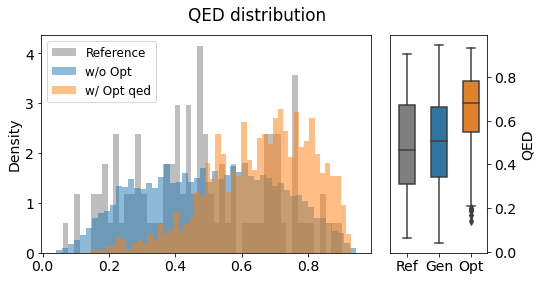

<Figure size 432x288 with 0 Axes>

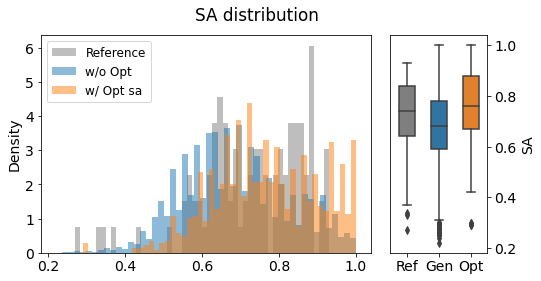

<Figure size 432x288 with 0 Axes>

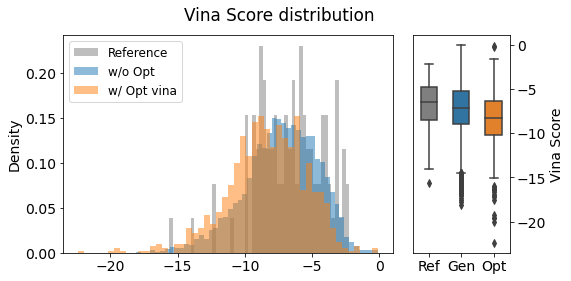

<Figure size 432x288 with 0 Axes>

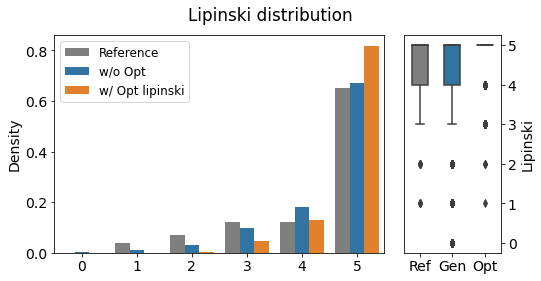

In [84]:
# set matplotlib font size to a larger one
plt.rcParams.update({'font.size': 14})
# set legend font size smaller
plt.rcParams.update({
    'legend.fontsize': '12',
    # 'legend.handlelength': 2
})

colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple', 'tab:brown', 'tab:pink', 'tab:gray', 'tab:olive']
ref_model = ref

for prop in ['qed', 'sa', 'vina', 'lipinski']:
    plt.figure()
    model = bfn_opts[prop]
    prop_list = get_prop_list(model, prop)
    ref_prop_list = get_prop_list(ref_model, prop)
    gen_prop_list = get_prop_list(bfn_ref, prop)
    fig, axs = plt.subplots(1, 2, figsize=(8, 4))
    # change colspan of axs
    axs[0] = plt.subplot2grid((1, 4), (0, 0), colspan=3)
    axs[1] = plt.subplot2grid((1, 4), (0, 3), colspan=1)
    # plot binned histogram with density for each property
    if prop in ['qed', 'sa']:
        prop_name = prop.upper()
    elif prop == 'vina':
        prop_list = [aff for aff in prop_list if aff < 0]
        ref_prop_list = [aff for aff in ref_prop_list if aff < 0]
        gen_prop_list = [aff for aff in gen_prop_list if aff < 0]
        prop_name = 'Vina Score'
    
    if prop in ['qed', 'sa', 'vina']:
        ref_prop_hist = np.histogram(ref_prop_list, bins=50)
        prop_hist = np.histogram(prop_list, bins=50)
        gen_prop_hist = np.histogram(gen_prop_list, bins=50)
        axs[0].hist(ref_prop_list, bins=50, label=ref_model.name, alpha=0.5, color='tab:gray', density=True)
        axs[0].hist(gen_prop_list, bins=50, label=bfn_ref.name, alpha=0.5, color=colors[0], density=True)
        axs[0].hist(prop_list, bins=50, label=model.name, alpha=0.5, color=colors[1], density=True)
    elif prop == 'lipinski':
        prop_name = prop.capitalize()
        x = np.arange(6)
        ref_prop_arr = np.array(ref_prop_list)
        prop_arr = np.array(prop_list)
        ref_prop_arr = np.array([np.sum(ref_prop_arr == i) for i in range(6)]) / len(ref_prop_arr)
        prop_arr = np.array([np.sum(prop_arr == i) for i in range(6)]) / len(prop_arr)
        gen_prop_arr = np.array(gen_prop_list)
        gen_prop_arr = np.array([np.sum(gen_prop_arr == i) for i in range(6)]) / len(gen_prop_arr)
        ref_dict = [{'x': i, 'y': ref_prop_arr[i], 'hue': ref_model.name} for i in range(6)]
        prop_dict = [{'x': i, 'y': prop_arr[i], 'hue': model.name} for i in range(6)]
        gen_dict = [{'x': i, 'y': gen_prop_arr[i], 'hue': bfn_ref.name} for i in range(6)]
        data_all = ref_dict + gen_dict + prop_dict 
        data_all = pd.DataFrame(data_all)
        sns.barplot(data=data_all, ax=axs[0], x='x', y='y', hue='hue', palette=['tab:gray', colors[0], colors[1]])
    else:
        raise ValueError(f"Unknown property {prop}")

    # plot boxplot for each property
    # TODO: change the boxplot x axis labels to model names
    sns.boxplot(data=[ref_prop_list, gen_prop_list, prop_list], ax=axs[1], width=0.5, palette=['tab:gray', colors[0], colors[1]])
 
    fig.suptitle(f'{prop_name} distribution')
    # set legend
    axs[0].legend()
    # remove x label for the first plot
    axs[0].set_xlabel('')
    axs[0].set_ylabel('Density')
    # set ax1 y label to appear on the right side of the plot
    axs[1].yaxis.tick_right()
    axs[1].yaxis.set_label_position('right')
    axs[1].set_ylabel(prop_name)
    axs[1].set_xticklabels(['Ref', 'Gen', 'Opt'])
    plt.savefig(f'{prop}_dist.pdf', bbox_inches='tight', dpi=300)


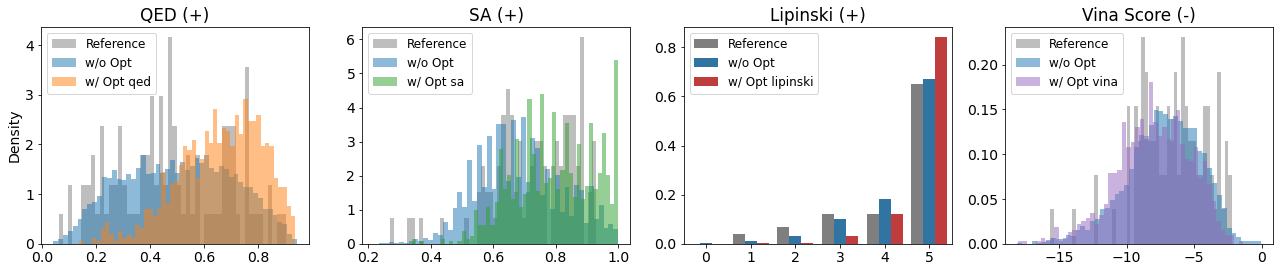

In [22]:
import sys
sys.path.append('..')

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import pandas as pd

from core.evaluation.utils.scoring_func import obey_lipinski

# An example of accessing the results
def get_prop_list(model, prop):
    if prop == 'lipinski':
        return [obey_lipinski(res['mol']) for res in model.flat_results]
    elif prop == 'vina':
        return [res['vina']['score_only'][0]['affinity'] for res in model.flat_results]
    elif prop in ['qed', 'sa']:
        return [res['chem_results'][prop] for res in model.flat_results]
    else:
        raise ValueError(f"Unknown property {prop}")



# set matplotlib font size to a larger one
plt.rcParams.update({'font.size': 14})
# set legend font size smaller
plt.rcParams.update({
    'legend.fontsize': '12',
    # 'legend.handlelength': 2
})

colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple', 'tab:brown', 'tab:pink', 'tab:gray', 'tab:olive']
ref_model = ref

# combine all properties into one plot

plt.figure(figsize=(6*3, 4))
plt.ylabel('Density')

for idx, prop in enumerate(['qed', 'sa', 'lipinski', 'vina']):
    plt.subplot(1, 4, idx+1)
    model = bfn_opts[prop]
    prop_list = get_prop_list(model, prop)
    ref_prop_list = get_prop_list(ref_model, prop)
    gen_prop_list = get_prop_list(bfn_ref, prop)
    # plot binned histogram with density for each property
    if prop in ['qed', 'sa']:
        prop_name = prop.upper() + ' (+)'
    elif prop == 'vina':
        prop_list = [aff for aff in prop_list if aff < 0]
        ref_prop_list = [aff for aff in ref_prop_list if aff < 0]
        gen_prop_list = [aff for aff in gen_prop_list if aff < 0]
        prop_name = 'Vina Score (-)'
    
    if prop in ['qed', 'sa', 'vina']:
        ref_prop_hist = np.histogram(ref_prop_list, bins=50)
        prop_hist = np.histogram(prop_list, bins=50)
        gen_prop_hist = np.histogram(gen_prop_list, bins=50)
        plt.hist(ref_prop_list, bins=50, label=ref_model.name, alpha=0.5, color='tab:gray', density=True)
        plt.hist(gen_prop_list, bins=50, label=bfn_ref.name, alpha=0.5, color=colors[0], density=True)
        plt.hist(prop_list, bins=50, label=model.name, alpha=0.5, color=colors[1+idx], density=True)
    elif prop == 'lipinski':
        prop_name = prop.capitalize() + ' (+)'
        x = np.arange(6)
        ref_prop_arr = np.array(ref_prop_list)
        prop_arr = np.array(prop_list)
        ref_prop_arr = np.array([np.sum(ref_prop_arr == i) for i in range(6)]) / len(ref_prop_arr)
        prop_arr = np.array([np.sum(prop_arr == i) for i in range(6)]) / len(prop_arr)
        gen_prop_arr = np.array(gen_prop_list)
        gen_prop_arr = np.array([np.sum(gen_prop_arr == i) for i in range(6)]) / len(gen_prop_arr)
        ref_dict = [{'x': i, 'y': ref_prop_arr[i], 'hue': ref_model.name} for i in range(6)]
        prop_dict = [{'x': i, 'y': prop_arr[i], 'hue': model.name} for i in range(6)]
        gen_dict = [{'x': i, 'y': gen_prop_arr[i], 'hue': bfn_ref.name} for i in range(6)]
        data_all = ref_dict + gen_dict + prop_dict
        data_all = pd.DataFrame(data_all)
        sns.barplot(data=data_all, x='x', y='y', hue='hue', palette=['tab:gray', colors[0], colors[1+idx]])
    else:
        raise ValueError(f"Unknown property {prop}")
    
    # set legend
    plt.legend()
    if idx != 0: 
        plt.ylabel('')
        plt.xlabel('')
    else: plt.ylabel('Density')
    plt.title(f'{prop_name}')

plt.tight_layout()
plt.savefig('all_dist.pdf', bbox_inches='tight', dpi=300)

In [2]:
import sys
import glob
import os
from rdkit import Chem
sys.path.append('..')

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import pandas as pd
from core.evaluation.utils.scoring_func import obey_lipinski

from eval_all_results import ModelResults
import os

opt_dir = '/sharefs/share/sbdd_data/opt_results'

ref_path = os.path.join(opt_dir, 'crossdocked_test_vina_docked.pt')
bfn_ref_path = os.path.join(opt_dir, 'bfn_vina_docked.pt')

opt_objectives = [
    'vina', 'sa', 'lipinski', 'vina_qed', 'vina_sa', 'vina_qed_sa', 
    'vina_qed_sa_lipinski',
    'qed'
]

result_dir = '/sharefs/qiukeyue/project/BFN4MolOpt'

bfn_opts = {}
for label in opt_objectives:
    sdf_path = os.path.join(result_dir, f'mols-{label}')
    bfn_opts[label] = ModelResults(f'w/ Opt {label}', os.path.join(sdf_path, 'temp_all.pt'))
    bfn_opts[label].load_pose_checked_sdf(sdf_path)

ref = ModelResults('Reference', ref_path)
bfn_ref = ModelResults('w/o Opt', bfn_ref_path)
ref.load_vina_docked()
bfn_ref.load_vina_docked()

models = [ref, bfn_ref] + list(bfn_opts.values())

colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple', 'tab:brown', 'tab:pink', 'tab:gray', 'tab:olive']
ref_model = ref

# An example of accessing the results
def get_prop_list(model, prop):
    if prop == 'lipinski':
        return [obey_lipinski(res['mol']) for res in model.flat_results]
    elif prop == 'vina':
        return [res['vina']['score_only'][0]['affinity'] for res in model.flat_results]
    elif prop in ['qed', 'sa']:
        return [res['chem_results'][prop] for res in model.flat_results]
    else:
        raise ValueError(f"Unknown property {prop}")

# combine all properties into one plot
# set matplotlib font size to a larger one
plt.rcParams.update({'font.size': 14})
# set legend font size smaller
plt.rcParams.update({
    'legend.fontsize': '12',
    # 'legend.handlelength': 2
})

plt.figure(figsize=(6*3, 4))
plt.ylabel('Density')

for idx, prop in enumerate(['qed', 'sa', 'lipinski', 'vina']):
    plt.subplot(1, 4, idx+1)
    model = bfn_opts[prop]
    prop_list = get_prop_list(model, prop)
    ref_prop_list = get_prop_list(ref_model, prop)
    gen_prop_list = get_prop_list(bfn_ref, prop)
    # plot binned histogram with density for each property
    if prop in ['qed', 'sa']:
        prop_name = prop.upper() + ' (+)'
    elif prop == 'vina':
        prop_list = [aff for aff in prop_list if aff < 0]
        ref_prop_list = [aff for aff in ref_prop_list if aff < 0]
        gen_prop_list = [aff for aff in gen_prop_list if aff < 0]
        prop_name = 'Vina Score (-)'
    
    if prop in ['qed', 'sa', 'vina']:
        ref_prop_hist = np.histogram(ref_prop_list, bins=50)
        prop_hist = np.histogram(prop_list, bins=50)
        gen_prop_hist = np.histogram(gen_prop_list, bins=50)
        plt.hist(ref_prop_list, bins=50, label=ref_model.name, alpha=0.5, color='tab:gray', density=True)
        plt.hist(gen_prop_list, bins=50, label=bfn_ref.name, alpha=0.5, color=colors[0], density=True)
        plt.hist(prop_list, bins=50, label=model.name, alpha=0.5, color=colors[1+idx], density=True)
    elif prop == 'lipinski':
        prop_name = prop.capitalize() + ' (+)'
        x = np.arange(6)
        ref_prop_arr = np.array(ref_prop_list)
        prop_arr = np.array(prop_list)
        ref_prop_arr = np.array([np.sum(ref_prop_arr == i) for i in range(6)]) / len(ref_prop_arr)
        prop_arr = np.array([np.sum(prop_arr == i) for i in range(6)]) / len(prop_arr)
        gen_prop_arr = np.array(gen_prop_list)
        gen_prop_arr = np.array([np.sum(gen_prop_arr == i) for i in range(6)]) / len(gen_prop_arr)
        ref_dict = [{'x': i, 'y': ref_prop_arr[i], 'hue': ref_model.name} for i in range(6)]
        prop_dict = [{'x': i, 'y': prop_arr[i], 'hue': model.name} for i in range(6)]
        gen_dict = [{'x': i, 'y': gen_prop_arr[i], 'hue': bfn_ref.name} for i in range(6)]
        data_all = ref_dict + gen_dict + prop_dict
        data_all = pd.DataFrame(data_all)
        sns.barplot(data=data_all, x='x', y='y', hue='hue', palette=['tab:gray', colors[0], colors[1+idx]])
    else:
        raise ValueError(f"Unknown property {prop}")
    
    # set legend
    plt.legend()
    if idx != 0: plt.ylabel('')
    else: plt.ylabel('Density')
    plt.title(f'{prop_name}')

plt.tight_layout()
plt.savefig('all_dist.pdf', bbox_inches='tight', dpi=300)

# Ablation

In [37]:
import pandas as pd

df = pd.read_csv('../ablation-strength.csv')
# drop the first column
df = df.drop(df.columns[0], axis=1)
# keep only the columns we need
df = df[['objective', 'w_pos', 'w_type', 'vina_score_mean', 'vina_score_median', 'vina_min_mean', 'vina_min_median', 'qed_mean', 'sa_mean', 'completeness']]
# set the precision to .2f
df = df.round(2)
# hide the index
# df.to_latex('project_table.tex', index=False)
df

,objective,w_pos,w_type,vina_score_mean,vina_score_median,vina_min_mean,vina_min_median,qed_mean,sa_mean,completeness
0,qed,0.1,0.1,-6.03,-6.92,-7.10,-7.19,0.51,0.70,0.97
1,qed,1.0,1.0,-6.24,-7.09,-7.31,-7.31,0.56,0.71,0.96
2,qed,10.0,10.0,-6.12,-7.07,-7.29,-7.41,0.66,0.71,0.98
3,qed,20.0,20.0,-6.33,-7.23,-7.34,-7.64,0.66,0.69,0.98
4,qed,50.0,50.0,-6.34,-6.96,-7.18,-7.24,0.64,0.65,0.96
5,qed,100.0,100.0,-6.25,-6.83,-7.02,-7.10,0.62,0.60,0.95
6,sa,0.1,0.1,-6.30,-7.11,-7.19,-7.29,0.50,0.70,0.96
7,sa,1.0,1.0,-6.17,-7.16,-7.36,-7.37,0.52,0.73,0.97
8,sa,10.0,10.0,-5.87,-7.23,-7.39,-7.72,0.57,0.78,0.98
9,sa,20.0,20.0,-6.14,-7.24,-7.49,-7.72,0.56,0.79,0.98


In [42]:
import pandas as pd

df = pd.read_csv('../project.csv')
# drop the first column
df = df.drop(df.columns[-2:], axis=1)
# keep only the columns we need
# df = df[['objective', 'w_pos', 'w_type', 'vina_score_mean', 'vina_score_median', 'vina_min_mean', 'vina_min_median', 'qed_mean', 'sa_mean', 'completeness']]
# set the precision to .2f
df = df.round(2)
# hide the index
# df.to_latex('project_table.tex', index=False)
df

,objective,vina_score_mean,vina_score_median,vina_min_mean,vina_min_median,qed_mean,sa_mean,completeness
0,lipinski,-6.30,-7.06,-7.14,-7.37,0.58,0.70,0.98
1,qed,-6.33,-7.23,-7.34,-7.64,0.66,0.69,0.98
2,qed,-6.42,-7.02,-7.32,-7.38,0.65,0.69,0.99
3,qed,-6.56,-7.07,-7.31,-7.40,0.66,0.70,0.99
4,qed_sa,-5.98,-6.93,-7.12,-7.33,0.65,0.75,0.98
5,sa,-6.14,-7.24,-7.49,-7.72,0.56,0.79,0.98
6,sa,-5.99,-7.34,-7.55,-7.76,0.56,0.79,0.98
7,vina,-7.03,-7.87,-7.84,-8.08,0.51,0.70,0.98
8,vina,-7.01,-7.85,-7.81,-8.15,0.53,0.70,0.97
9,vina,-6.98,-7.79,-7.78,-7.97,0.51,0.70,0.97


# Case study: interaction visualization for R-group design & Scaffold Hopping

## R-group

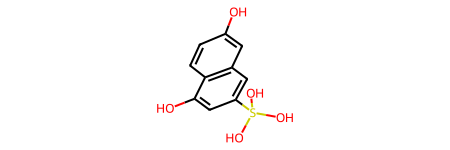

In [22]:
compare_mol = Chem.SDMolSupplier('../mols-inpaint/mols-vina_sa_prior20/360.sdf')[0]
compare_mol

In [23]:
from core.evaluation.utils.sascorer import compute_sa_score
comp_qed = Chem.QED.qed(compare_mol)
comp_sa = compute_sa_score(compare_mol)
comp_qed, comp_sa, float(compare_mol.GetProp('vina_score'))

(0.5289888968616422, 0.83, -7.579)

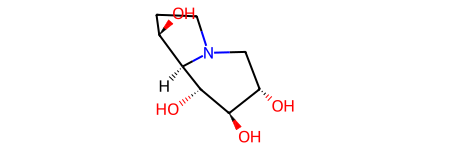

In [10]:
ligand_imp = compare_mol.GetProp('_Name')
ref_fns = [r['ligand_filename'] for r in ref.flat_results]
ref_mol_imp = ref.flat_results[ref_fns.index(ligand_imp)]['mol']
ref_mol_imp

In [12]:
ref_mol_vina = ref.flat_results[ref_fns.index(ligand_imp)]['vina']
ref_mol_qed = ref.flat_results[ref_fns.index(ligand_imp)]['chem_results']['qed']
ref_mol_sa = ref.flat_results[ref_fns.index(ligand_imp)]['chem_results']['sa']
ref_mol_qed, ref_mol_sa, ref_mol_vina['score_only'][0]['affinity']

(0.33891445297146083, 0.66, -5.452)

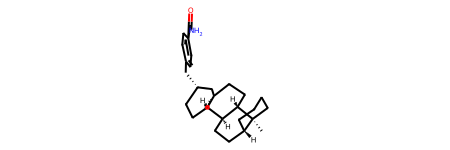

In [32]:
compare_mol = Chem.SDMolSupplier('../mols-inpaint/mols-vina_sa_prior20/204.sdf')[0]
compare_mol

In [33]:
comp_qed = Chem.QED.qed(compare_mol)
comp_sa = compute_sa_score(compare_mol)
comp_qed, comp_sa, float(compare_mol.GetProp('vina_score'))

(0.6361676908785369, 0.68, -11.282)

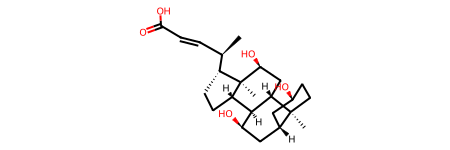

In [34]:
ligand_imp = compare_mol.GetProp('_Name')
ref_fns = [r['ligand_filename'] for r in ref.flat_results]
ref_mol_imp = ref.flat_results[ref_fns.index(ligand_imp)]['mol']
ref_mol_imp

In [35]:
ref_mol_vina = ref.flat_results[ref_fns.index(ligand_imp)]['vina']
ref_mol_qed = ref.flat_results[ref_fns.index(ligand_imp)]['chem_results']['qed']
ref_mol_sa = ref.flat_results[ref_fns.index(ligand_imp)]['chem_results']['sa']
ref_mol_qed, ref_mol_sa, ref_mol_vina['score_only'][0]['affinity']

(0.5396325132302963, 0.58, -9.929)

## Scaffold Hopping

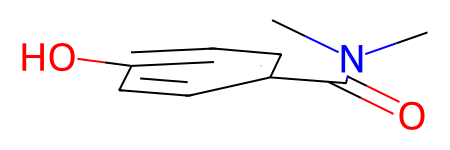

In [24]:
sca_mol = Chem.SDMolSupplier('../mols-scaffold/mols-vina_qed_sa_prior20_scaffold/173.sdf')[0]
sca_mol

In [25]:
sca_qed = Chem.QED.qed(sca_mol)
sca_sa = compute_sa_score(sca_mol)
sca_qed, sca_sa, float(sca_mol.GetProp('vina_score'))

(0.6763840517918872, 0.94, -5.333)

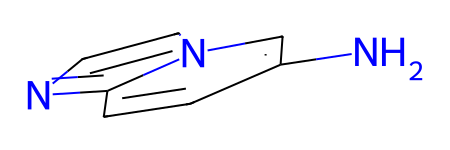

In [26]:
ligand_fn = sca_mol.GetProp('_Name')
ref_mol_sca = ref.flat_results[ref_fns.index(ligand_fn)]['mol']
ref_mol_sca

In [27]:
ref_mol_vina = ref.flat_results[ref_fns.index(ligand_fn)]['vina']
ref_mol_qed = ref.flat_results[ref_fns.index(ligand_fn)]['chem_results']['qed']
ref_mol_sa = ref.flat_results[ref_fns.index(ligand_fn)]['chem_results']['sa']
assert ref_mol_qed == Chem.QED.qed(ref_mol_sca) and ref_mol_sa == compute_sa_score(ref_mol_sca)
print( 
ref_mol_vina['score_only'][0]['affinity'], ref_mol_qed, ref_mol_sa
)

-4.401 0.5802327471587276 0.83


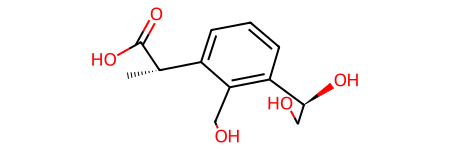

In [28]:
sca_mol = Chem.SDMolSupplier('../mols-scaffold/mols-vina_qed_sa_prior20_scaffold/960.sdf')[0]
sca_mol

In [29]:
sca_qed = Chem.QED.qed(sca_mol)
sca_sa = compute_sa_score(sca_mol)
sca_qed, sca_sa, float(sca_mol.GetProp('vina_score'))

(0.5966514566935309, 0.74, -5.984)

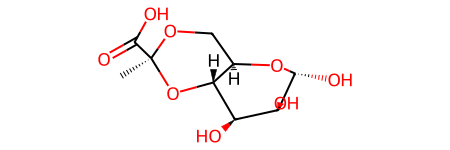

In [30]:
ligand_fn = sca_mol.GetProp('_Name')
ref_mol_sca = ref.flat_results[ref_fns.index(ligand_fn)]['mol']
ref_mol_sca

In [31]:
ref_mol_vina = ref.flat_results[ref_fns.index(ligand_fn)]['vina']
ref_mol_qed = ref.flat_results[ref_fns.index(ligand_fn)]['chem_results']['qed']
ref_mol_sa = ref.flat_results[ref_fns.index(ligand_fn)]['chem_results']['sa']
assert ref_mol_qed == Chem.QED.qed(ref_mol_sca) and ref_mol_sa == compute_sa_score(ref_mol_sca)
print( 
ref_mol_vina['score_only'][0]['affinity'], ref_mol_qed, ref_mol_sa
)

-5.393 0.4070282264144997 0.62


In [79]:
import glob

model_inpainting = ModelResults('Inpainting', '../mols-inpaint/mols-vina_sa_prior20/temp_all.pt')
model_fns = glob.glob('../mols-inpaint/mols-vina_sa_prior20/*.sdf')
model_results = [Chem.SDMolSupplier(fn)[0] for fn in model_fns]
model_fns = [fn for fn in model_fns if model_results[model_fns.index(fn)] is not None]
model_results = [mol for mol in model_results if mol is not None]
model_inpainting.flat_results = [{'mol': mol, 'ligand_filename': mol.GetProp('_Name')} for mol in model_results]

molist = [r['mol'] for r in model_inpainting.flat_results]
qed_list = [Chem.QED.qed(mol) for mol in molist]
sa_list = [compute_sa_score(mol) for mol in molist]
vina_list = [float(r['mol'].GetProp('vina_score')) if r['mol'].HasProp('vina_score') else 0 for r in model_inpainting.flat_results]

ref_list = [ref.flat_results[ref_fns.index(mol.GetProp('_Name'))]['mol'] for mol in molist]
ref_qed_list = [Chem.QED.qed(mol) for mol in ref_list]
ref_sa_list = [compute_sa_score(mol) for mol in ref_list]
ref_vina_list = [float(ref.flat_results[ref_fns.index(mol.GetProp('_Name'))]['vina']['score_only'][0]['affinity']) for mol in molist]

import numpy as np
all_improved = np.array([q >= rq - 0.005 and s >= rs - 0.005 and v < rv for q, rq, s, rs, v, rv in zip(qed_list, ref_qed_list, sa_list, ref_sa_list, vina_list, ref_vina_list)])
fn_improved = sorted([fn for fn, imp in zip(model_fns, all_improved) if imp], key=lambda x: int(x.split('/')[-1].split('.')[0]))
len(fn_improved)

96

In [80]:
with open('improved_inpainting.txt', 'w') as f:
    f.write('\n'.join(fn_improved))

In [75]:
import glob

model_inpainting = ModelResults('Scaffold', '../mols-scaffold/mols-vina_qed_sa_prior20_scaffold/temp_all.pt')
model_fns = glob.glob('../mols-scaffold/mols-vina_qed_sa_prior20_scaffold/*.sdf')
model_results = [Chem.SDMolSupplier(fn)[0] for fn in model_fns]
model_fns = [fn for fn in model_fns if model_results[model_fns.index(fn)] is not None]
model_results = [mol for mol in model_results if mol is not None]
model_inpainting.flat_results = [{'mol': mol, 'ligand_filename': mol.GetProp('_Name')} for mol in model_results]

molist = [r['mol'] for r in model_inpainting.flat_results]
qed_list = [Chem.QED.qed(mol) for mol in molist]
sa_list = [compute_sa_score(mol) for mol in molist]
vina_list = [float(r['mol'].GetProp('vina_score')) if r['mol'].HasProp('vina_score') else 0 for r in model_inpainting.flat_results]

ref_list = [ref.flat_results[ref_fns.index(mol.GetProp('_Name'))]['mol'] for mol in molist]
ref_qed_list = [Chem.QED.qed(mol) for mol in ref_list]
ref_sa_list = [compute_sa_score(mol) for mol in ref_list]
ref_vina_list = [float(ref.flat_results[ref_fns.index(mol.GetProp('_Name'))]['vina']['score_only'][0]['affinity']) for mol in molist]

import numpy as np
all_improved = np.array([q >= rq - 0.005 and s >= rs - 0.005 and v < rv for q, rq, s, rs, v, rv in zip(qed_list, ref_qed_list, sa_list, ref_sa_list, vina_list, ref_vina_list)])
fn_improved = sorted([fn for fn, imp in zip(model_fns, all_improved) if imp])
len(fn_improved)

125

In [77]:
fn_improved = sorted([fn for fn, imp in zip(model_fns, all_improved) if imp], key=lambda x: int(x.split('/')[-1].split('.')[0]))
with open('improved_scaffold.txt', 'w') as f:
    f.write('\n'.join(fn_improved))

## Visualize classifier loss

### Affinity (un-normalize from 1 to 16x)

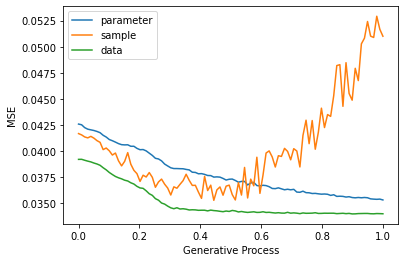

In [23]:
import numpy as np
import torch
import matplotlib.pyplot as plt

classifier_dict = {
    'parameter': 'train_prop/train_prop_affinity_28c0876_5352',
    # 'sample': 'train_prop_noisy/train_prop_noisy_affinity_f9ad1cb_24434',
    'sample': 'train_prop_noisy/train_prop_noisy_affinity_6141c36_18919',
    'data': 'train_prop_x0/affinity_7ec42d8_17211',
}

classifier_results = {}
for key, value in classifier_dict.items():
    classifier_results[key] = torch.load(f'/sharefs/qiukeyue/project/logs/qiukeyue_bfn_molopt/{value}/checkpoints/loss_traj.pt')
    # plot the loss trajectory
    plt.plot(np.linspace(0, 1, 100), classifier_results[key], label=key)

plt.xlabel('Generative Process')
plt.ylabel('MSE')
plt.legend()
plt.show()

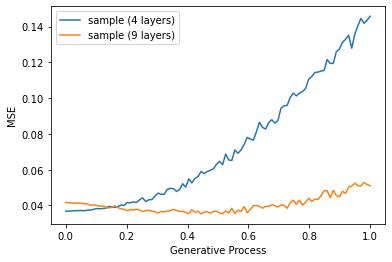

In [22]:
import numpy as np
import torch
import matplotlib.pyplot as plt

classifier_dict = {
    # 'parameter': 'train_prop/train_prop_affinity_28c0876_5352',
    'sample (4 layers)': 'train_prop_noisy/train_prop_noisy_affinity_f9ad1cb_24434',
    'sample (9 layers)': 'train_prop_noisy/train_prop_noisy_affinity_6141c36_18919',
    # 'data': 'train_prop_x0/affinity_7ec42d8_17211',
}

plt.figure()
classifier_results = {}
for key, value in classifier_dict.items():
    classifier_results[key] = torch.load(f'/sharefs/qiukeyue/project/logs/qiukeyue_bfn_molopt/{value}/checkpoints/loss_traj.pt')
    # plot the loss trajectory
    plt.plot(np.linspace(0, 1, 100), classifier_results[key], label=key)

plt.xlabel('Generative Process')
plt.ylabel('MSE')
plt.legend()
plt.show()

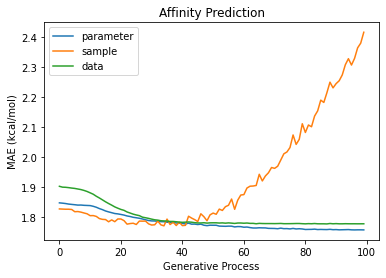

In [17]:
import numpy as np
import torch
import matplotlib.pyplot as plt

classifier_dict = {
    'parameter': 'train_prop/train_prop_affinity_28c0876_5352',
    # 'sample (4)': 'train_prop_noisy/train_prop_noisy_affinity_f9ad1cb_24434',
    'sample': 'train_prop_noisy/train_prop_noisy_affinity_6141c36_18919',
    'data': 'train_prop_x0/affinity_7ec42d8_17211',
}

classifier_results = {}
for key, value in classifier_dict.items():
    classifier_results[key] = torch.load(f'/sharefs/qiukeyue/project/logs/qiukeyue_bfn_molopt/{value}/checkpoints/loss_traj.pt')
    # plot the loss trajectory
    plt.plot(classifier_results[key], label=key)

# plt.hlines(2.3, 0, 1, colors='gray', linestyles='dashed')

plt.title('Affinity Prediction')
plt.xlabel('Generative Process')
plt.ylabel('MAE (kcal/mol)')
plt.legend()
plt.show()

### QED, SA

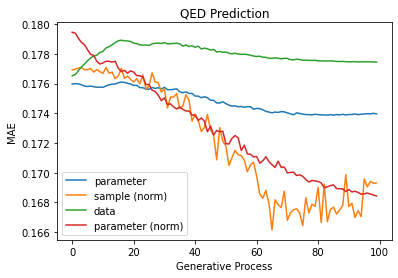

In [20]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import os

classifier_dict = {
    'parameter': 'train_prop/train_prop_qed_28c0876_9549',
    # 'sample (4)': 'train_prop_noisy/train_prop_noisy_qed_f9ad1cb_28735',
    'sample (norm)': 'train_prop_noisy/train_prop_noisy_qed_norm_6141c36_30294',
    'data': 'train_prop_x0/qed_7ec42d8_27269',
    'parameter (norm)': 'train_prop/train_prop_qed_norm_b4418d7_30976',
}

classifier_results = {}
for key, value in classifier_dict.items():
    if not os.path.exists(f'/sharefs/qiukeyue/project/logs/qiukeyue_bfn_molopt/{value}/checkpoints/loss_traj.pt'):
        print(f"File {value} does not exist. Skip.")
        continue
    classifier_results[key] = torch.load(f'/sharefs/qiukeyue/project/logs/qiukeyue_bfn_molopt/{value}/checkpoints/loss_traj.pt')
    # plot the loss trajectory
    if len(classifier_results[key]) == 1000:
        classifier_results[key] = classifier_results[key][::10]
    plt.plot(classifier_results[key], label=key)

# plt.hlines(2.3, 0, 1, colors='gray', linestyles='dashed')

plt.title('QED Prediction')
plt.xlabel('Generative Process')
plt.ylabel('MAE')
plt.legend()
plt.show()

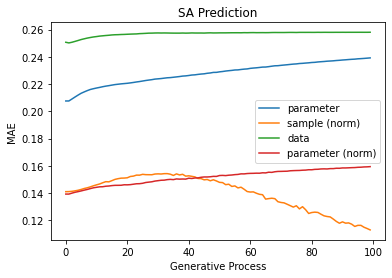

In [21]:
import numpy as np
import torch
import matplotlib.pyplot as plt

classifier_dict = {
    'parameter': 'train_prop/train_prop_sa_28c0876_5874',
    # 'sample (4)': 'train_prop_noisy/train_prop_noisy_sa_f9ad1cb_28066',
    'sample (norm)': 'train_prop_noisy/train_prop_noisy_sa_norm_6141c36_8501',
    'data': 'train_prop_x0/sa_7ec42d8_329',
    'parameter (norm)': 'train_prop/train_prop_sa_norm_b4418d7_8911',
}

classifier_results = {}
for key, value in classifier_dict.items():
    if not os.path.exists(f'/sharefs/qiukeyue/project/logs/qiukeyue_bfn_molopt/{value}/checkpoints/loss_traj.pt'):
        print(f"File {value} does not exist. Skip.")
        continue
    classifier_results[key] = torch.load(f'/sharefs/qiukeyue/project/logs/qiukeyue_bfn_molopt/{value}/checkpoints/loss_traj.pt')
    # plot the loss trajectory
    if len(classifier_results[key]) == 1000:
        classifier_results[key] = classifier_results[key][::10]
    plt.plot(classifier_results[key], label=key)

# plt.hlines(2.3, 0, 1, colors='gray', linestyles='dashed')

plt.title('SA Prediction')
plt.xlabel('Generative Process')
plt.ylabel('MAE')
plt.legend()
plt.show()